 <h1 style="font-size:2em;color:#2467C0">Phase 2 Urban World Prediction Challenge</h1>

Import libraries

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime
from datetime import timedelta

Loading dataset

In [2]:
base_dir = os.path.abspath('../data') 
initial_data_file_1 = base_dir + r'/RunDataTable.tsv'
initial_data_file_2 = base_dir + r'/Urban World Predict Challenge Data/RunDataTable.tsv'
rr_0260_data_file = base_dir + r'/Urban World Predict Challenge Data/RR-0260-RunDataTable.tsv'
rr_0310_data_file = base_dir + r'/Urban World Predict Challenge Data/RR-0310-RunDataTable.tsv'
rr_0320_data_file = base_dir + r'/Urban World Predict Challenge Data/RR-0320-RunDataTable.tsv'
rr_0330_data_file = base_dir + r'/Urban World Predict Challenge Data/RR-0330-RunDataTable.tsv'
rr_0340_qualitative_data_file = base_dir + r'/Urban World Predict Challenge Data/RR-0340-QualitativeDataTable.tsv'
rr_0340_relationship_data_file = base_dir + r'/Urban World Predict Challenge Data/RR-0340-RelationshipDataTable.tsv'
rr_0340_data_file = base_dir + r'/Urban World Predict Challenge Data/RR-0340-RunDataTable.tsv'
rr_0370_qualitative_data_file = base_dir + r'/Urban World Predict Challenge Data/RR-0370-QualitativeDataTable.tsv'
rr_0370_data_file = base_dir + r'/Urban World Predict Challenge Data/RR-0370-RunDataTable.tsv'
rr_0380_data_file = base_dir + r'/Urban World Predict Challenge Data/RR-0380-RunDataTable.tsv'
rr_0390_data_file = base_dir + r'/Urban World Predict Challenge Data/RR-0390-RunDataTable.tsv'
idp_sup_data_file = base_dir + r'/Urban World Predict Challenge Data/IDP_SUP_RunDataTable.tsv'

In [3]:
initial_data_1 = pd.read_table(initial_data_file_1,parse_dates=True)
initial_data_1['VariableName'].unique()
# initial_data_1[initial_data_1['VariableName']=='OngoingMeetingId']

array(['CurrentVisitor', 'OngoingMeetingId', 'Participant', 'Checkin',
       'Checkout', 'SiteType', 'SiteLocation', 'BuildingId', 'ApproxAge',
       'HomeLocation', 'WorkLocation', 'IncomePerHour'], dtype=object)

In [4]:
initial_data_2 = pd.read_csv(initial_data_file_2,delimiter='\t',encoding='utf-8', index_col=False)
initial_data_2['VariableName'].unique()

/home/workstation/software/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


array(['CurrentVisitor', 'OngoingMeetingId', 'Participant', 'Enter',
       'Leave', 'Checkin', 'Checkout'], dtype=object)

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold">
Predict Test Question 1a
</p> 

<p style="font-family: Arial; font-size:1.25em;color:#2462C0; font-style:bold">
Data preprocessing</p>

The function below returns a dataset of total number of visit per day for a specific site.

In [5]:
def get_visit_data(data, site_id):
    visit_data = data[data['VariableName']=='CurrentVisitor']
    visit_data = visit_data[visit_data['EntityIdx']==site_id]
    visit_data = pd.DataFrame(visit_data.groupby('Timestep')['Value'].apply(' '.join))
    visit_data['Prev_value'] = visit_data.shift(1)['Value']
    if visit_data.empty == True:
        return pd.DataFrame()
    def func(x):
        if pd.isna(x['Value'])==False:
            a = set(x['Value'].split())
        else:
            a=set()
    
        if pd.isna(x['Prev_value'])==False:
            b = set(x['Prev_value'].split())
        else:
            b = set()
        return len(a.difference(b))
 
    visit_data[site_id]=visit_data.apply(lambda x: func(x),  axis=1)
    visit_data.index = pd.to_datetime(visit_data.index)
    visit_data=visit_data.resample('D').sum()
    return visit_data

Function to normalize data.

In [6]:
def normalize(data, train_split):
    mean = data[:TRAIN_SPLIT].mean()
    std = data[:TRAIN_SPLIT].std()
    data = (data-mean)/std
    return data


In [7]:
    
PRED_SITES=['Site-2629','Site-5298','Site-5299','Site-10648', 'Site-7976']

CLOSED_SITES =['Site-2627', 'Site-2628', 'Site-2630', 'Site-2634', 'Site-2636',
                'Site-2637', 'Site-2638', 'Site-5297', 'Site-5300', 'Site-5308',
                'Site-5309', 'Site-5311', 'Site-7968', 'Site-7969', 'Site-7979',
                'Site-10640', 'Site-10649', 'Site-10650', 'Site-10651', 'Site-10652']

# site_2629_meeting_data_1 = get_meeting_data(initial_data_1, 'Site-2629')
# site_2629_meeting_data_2 = get_meeting_data(initial_data_2, 'Site-2629')
# site_2629_meeting_data =  pd.concat([site_2629_meeting_data_1, site_2629_meeting_data_2])


sites_visit_data_scene_1={}
for site in PRED_SITES:
    data_1 = get_visit_data(initial_data_1, site)
    data_2 = get_visit_data(initial_data_2, site)
    data=pd.concat([data_1, data_2])
    sites_visit_data_scene_1[site]=data

    
sites_visit_data_scene_1[PRED_SITES[0]]


,Site-2629
Timestep,
2019-08-01,294
2019-08-02,268
2019-08-03,545
2019-08-04,497
2019-08-05,205
...,...
2022-07-09,49
2022-07-10,0
2022-07-11,69


In [8]:
close_sites_visit_data = {}
for close_site in CLOSED_SITES:
        close_site_visit_data_1 = get_visit_data(initial_data_1, close_site)
        close_site_visit_data_2 = get_visit_data(initial_data_2, close_site)
        close_site_visit_data = pd.concat([close_site_visit_data_1, close_site_visit_data_2])
        close_sites_visit_data[close_site] = close_site_visit_data
#         print(close_site_visit_data)

def concat_site_visit_data(site, close_sites_visit_data):
    site_data_1 = get_visit_data(initial_data_1, site)
    site_data_2 = get_visit_data(initial_data_2, site)
    site_data =  pd.concat([site_data_1, site_data_2])

    ret = site_data
    for close_site in CLOSED_SITES:
        close_site_visit_data = close_sites_visit_data[close_site]
#         print(close_site_visit_data)
        ret = pd.concat([ret,close_site_visit_data], axis=1, sort=False)
    return ret

sites_visit_data_scene_2={}
for site in PRED_SITES:
    concat_site_data=concat_site_visit_data(site,close_sites_visit_data)
    sites_visit_data_scene_2[site]=concat_site_data
    sites_visit_data_scene_2[site]=sites_visit_data_scene_2[site].fillna(0)

In [9]:
sites_visit_data_scene_1[PRED_SITES[0]]

,Site-2629
Timestep,
2019-08-01,294
2019-08-02,268
2019-08-03,545
2019-08-04,497
2019-08-05,205
...,...
2022-07-09,49
2022-07-10,0
2022-07-11,69


Now we have to divide data into features and labels. For time series data features are previous obeserved values and label is the value to be predicted. Here, the number of features is called window size and a slice of the time series of length equal to window size is called a window. The following function creates a windowed dataset from the given time series. Here target_size is the number of future predicted values.

In [10]:
def windowed_data(dataframe, window_size, target_size, batch_size,shuffle=True, repeat = True):
    dataset = tf.data.Dataset.from_tensor_slices(dataframe)
    dataset = dataset.window(window_size+target_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+target_size))
    dataset = dataset.shuffle(1000)
    dataset = dataset.map(lambda window: (window[:-target_size],window[-target_size:]))
    dataset = dataset.batch(batch_size)
    if repeat:
        dataset = dataset.repeat()
    return dataset

We have to split the data into train and validation set. We set training data size to 100. the rest of the data will be used for validation. Window size is set to 8 and future target size is set to 5.

In [21]:
TRAIN_SPLIT = 100
BATCH_SIZE = 100
window_size = 7
target_size = 5
REPEAT = True

In [22]:
# site_2629_meeting_values = site_2629_meeting_data.values
# site_2629_meeting_values.shape
sites_visit_train_dataset_scene_1={}
sites_visit_validation_dataset_scene_1={}
for site_key in sites_visit_data_scene_1:
    data=sites_visit_data_scene_1[site_key]
    sites_visit_train_dataset_scene_1[site_key]=windowed_data(data.values[:TRAIN_SPLIT], window_size, target_size, BATCH_SIZE, repeat= REPEAT)
    sites_visit_validation_dataset_scene_1[site_key]=windowed_data(data.values[TRAIN_SPLIT:], window_size, target_size, BATCH_SIZE,repeat = REPEAT)


In [23]:
# site_2629_train_dataset = windowed_data(site_2629_meeting_values[:TRAIN_SPLIT], window_size, target_size, BATCH_SIZE)
# site_2629_validation_dataset = windowed_data(site_2629_meeting_values[TRAIN_SPLIT:], window_size, target_size, BATCH_SIZE)

for x, y in sites_visit_train_dataset_scene_1['Site-2629'].take(1):
    print('x=',x.shape, 'y=',y.shape)
#     print('x=',x.numpy(), 'y=',y.numpy())

x= (89, 7, 1) y= (89, 5, 1)


For scenerio 2 we use the close site visit information as features to see the influence of closed sites on selected site visit.

In [24]:
def multivariate_windowed_data(dataframe, window_size, target_size, batch_size,shuffle=True, repeat = True):
    dataset = tf.data.Dataset.from_tensor_slices(dataframe)
    dataset = dataset.window(window_size+target_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+target_size))
    dataset = dataset.shuffle(1000)
    dataset = dataset.map(lambda window: (window[:-target_size],window[-target_size:,0:1]))
    dataset = dataset.batch(batch_size)
    if repeat:
        dataset = dataset.repeat()
    return dataset
    

In [25]:
# site_2629_meeting_values = site_2629_meeting_data.values
# site_2629_meeting_values.shape
sites_visit_train_dataset_scene_2={}
sites_visit_validation_dataset_scene_2={}
for site_key in sites_visit_data_scene_2:
    data=sites_visit_data_scene_2[site_key]
    sites_visit_train_dataset_scene_2[site_key]=multivariate_windowed_data(data.values[:TRAIN_SPLIT], window_size, target_size, BATCH_SIZE)
    sites_visit_validation_dataset_scene_2[site_key]=multivariate_windowed_data(data.values[TRAIN_SPLIT:], window_size, target_size, BATCH_SIZE)


In [109]:
# site_2629_train_dataset = windowed_data(site_2629_meeting_values[:TRAIN_SPLIT], window_size, target_size, BATCH_SIZE)
# site_2629_validation_dataset = windowed_data(site_2629_meeting_values[TRAIN_SPLIT:], window_size, target_size, BATCH_SIZE)

for x, y in sites_visit_train_dataset_scene_2['Site-2629'].take(1):
    print('x=',x.shape, 'y=',y.shape)
#     print('x=',x.numpy(), 'y=',y.numpy())

x= (50, 7, 21) y= (50, 5, 1)


<p style="font-family: Arial; font-size:1.25em;color:#2462C0; font-style:bold">
Building and Training Model for Scenerio 1</p>

The below function plots loss history of the model.

In [14]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

This function plot forcast for scene 1. 

In [29]:
def plot_forecast_scene_1(model, data, site, window_size,target_size):
    forecast = []
    values=data.values
    for time in range(0, len(values) - window_size,target_size):
        pred = model.predict(values[time:time + window_size][np.newaxis].astype(np.float32))
        pred = pred.reshape(target_size)
        forecast.append(pred)
    forecast = np.array(forecast).reshape(-1)
    res = pd.concat([data[window_size:].reset_index()[site], pd.DataFrame(forecast)], axis =1)
    res.plot()

The function below returns prediction for 30 days from P-day.


In [16]:
def p_day_forecast_scene_1(model, data, site, window_size, target_size):
    last_date=data.index[-1]
    p_day = datetime(2022, 7, 15)
    delta = p_day-last_date
    x = data.values[-window_size:]
    for time in range (0, 30 + delta.days,target_size):
        pred = model.predict(x[np.newaxis, time:time+window_size].astype(np.float32)) 
        pred = pred.reshape((target_size,1))
        pred=np.rint(pred) 
        x = np.concatenate([x, pred], axis=0)
    
    index=pd.date_range(data.index[-window_size], periods=x.shape[0])
    x=pd.DataFrame(x,index=index, columns=['Value'])
    x.index.rename('Timestep',inplace=True)
    x = x[p_day:p_day+timedelta(30)]
    x['Scenario']='Scenario 1'
    x['Site'] = site
    x = x.reset_index()
    x=x[['Scenario', 'Site', 'Timestep', 'Value']]
    return x

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe969c6d8d0>,
      dtype=object)

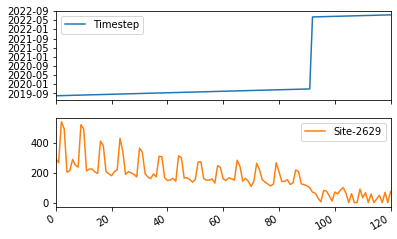

In [17]:
sites_visit_data_scene_1['Site-2629'].reset_index().plot(subplots=True)

In [19]:
def train_model(model, train_dataset, validation_dataset, epochs, steps_per_epoch, validation_steps):
    model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
#     history = model.fit(train_dataset, epochs=epochs,validation_data=validation_dataset,
#                         steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
    history = model.fit(train_dataset, epochs=epochs,validation_data=validation_dataset)
                        
    return history

In [69]:
site='Site-2629'
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.GRU(128,
                     dropout=0.2,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, 1)))
model.add(tf.keras.layers.GRU(128,
                              return_sequences=True,
                     dropout=0.2,
                     recurrent_dropout=0.5
                     ))
model.add(tf.keras.layers.GRU(128,
                     dropout=0.2,
                     recurrent_dropout=0.5,
                              activation='relu'
                     ))
model.add(tf.keras.layers.Dense(target_size, activation = 'relu'))
history = train_model( model , sites_visit_train_dataset_scene_1[site], 
                             sites_visit_validation_dataset_scene_1[site], 1000,100,100)

Epoch 1/1000
1/1 [==============================] - 5s 5s/step - loss: 192.2591 - val_loss: 0.0000e+00
Epoch 2/1000
1/1 [==============================] - 0s 64ms/step - loss: 189.0378 - val_loss: 33.0837
Epoch 3/1000
1/1 [==============================] - 0s 68ms/step - loss: 180.0991 - val_loss: 32.6043
Epoch 4/1000
1/1 [==============================] - 0s 69ms/step - loss: 167.0389 - val_loss: 31.7605
Epoch 5/1000
1/1 [==============================] - 0s 69ms/step - loss: 145.2293 - val_loss: 30.2824
Epoch 6/1000
1/1 [==============================] - 0s 72ms/step - loss: 111.9422 - val_loss: 28.2040
Epoch 7/1000
1/1 [==============================] - 0s 70ms/step - loss: 91.1315 - val_loss: 28.6543
Epoch 8/1000
1/1 [==============================] - 0s 70ms/step - loss: 96.3726 - val_loss: 28.3040
Epoch 9/1000
1/1 [==============================] - 0s 74ms/step - loss: 100.7512 - val_loss: 28.7832
Epoch 10/1000
1/1 [==============================] - 0s 79ms/step - loss: 91.5620 -

Epoch 82/1000
1/1 [==============================] - 0s 79ms/step - loss: 67.1530 - val_loss: 29.7403
Epoch 83/1000
1/1 [==============================] - 0s 79ms/step - loss: 67.1116 - val_loss: 28.7366
Epoch 84/1000
1/1 [==============================] - 0s 94ms/step - loss: 65.8206 - val_loss: 29.5645
Epoch 85/1000
1/1 [==============================] - 0s 95ms/step - loss: 62.5065 - val_loss: 29.1149
Epoch 86/1000
1/1 [==============================] - 0s 89ms/step - loss: 61.8652 - val_loss: 29.4790
Epoch 87/1000
1/1 [==============================] - 0s 77ms/step - loss: 58.9004 - val_loss: 29.3313
Epoch 88/1000
1/1 [==============================] - 0s 70ms/step - loss: 62.5176 - val_loss: 29.5561
Epoch 89/1000
1/1 [==============================] - 0s 68ms/step - loss: 61.7878 - val_loss: 29.1921
Epoch 90/1000
1/1 [==============================] - 0s 67ms/step - loss: 61.4953 - val_loss: 29.6582
Epoch 91/1000
1/1 [==============================] - 0s 66ms/step - loss: 62.0769 

Epoch 162/1000
1/1 [==============================] - 0s 75ms/step - loss: 59.9662 - val_loss: 29.4197
Epoch 163/1000
1/1 [==============================] - 0s 75ms/step - loss: 61.9455 - val_loss: 30.1955
Epoch 164/1000
1/1 [==============================] - 0s 72ms/step - loss: 64.8631 - val_loss: 29.4539
Epoch 165/1000
1/1 [==============================] - 0s 69ms/step - loss: 64.9392 - val_loss: 30.4367
Epoch 166/1000
1/1 [==============================] - 0s 70ms/step - loss: 66.3749 - val_loss: 29.4706
Epoch 167/1000
1/1 [==============================] - 0s 71ms/step - loss: 64.1422 - val_loss: 30.2076
Epoch 168/1000
1/1 [==============================] - 0s 65ms/step - loss: 60.2820 - val_loss: 29.5648
Epoch 169/1000
1/1 [==============================] - 0s 69ms/step - loss: 61.7957 - val_loss: 30.0766
Epoch 170/1000
1/1 [==============================] - 0s 69ms/step - loss: 61.4890 - val_loss: 29.5856
Epoch 171/1000
1/1 [==============================] - 0s 67ms/step - loss

Epoch 242/1000
1/1 [==============================] - 0s 68ms/step - loss: 57.3189 - val_loss: 30.1755
Epoch 243/1000
1/1 [==============================] - 0s 75ms/step - loss: 57.1161 - val_loss: 30.1137
Epoch 244/1000
1/1 [==============================] - 0s 74ms/step - loss: 56.6121 - val_loss: 30.6640
Epoch 245/1000
1/1 [==============================] - 0s 78ms/step - loss: 60.2635 - val_loss: 29.8105
Epoch 246/1000
1/1 [==============================] - 0s 75ms/step - loss: 64.4260 - val_loss: 30.7273
Epoch 247/1000
1/1 [==============================] - 0s 77ms/step - loss: 63.0698 - val_loss: 29.8168
Epoch 248/1000
1/1 [==============================] - 0s 80ms/step - loss: 60.0910 - val_loss: 30.4513
Epoch 249/1000
1/1 [==============================] - 0s 76ms/step - loss: 55.8941 - val_loss: 30.2156
Epoch 250/1000
1/1 [==============================] - 0s 74ms/step - loss: 57.5883 - val_loss: 30.4379
Epoch 251/1000
1/1 [==============================] - 0s 70ms/step - loss

Epoch 322/1000
1/1 [==============================] - 0s 76ms/step - loss: 56.8669 - val_loss: 29.9370
Epoch 323/1000
1/1 [==============================] - 0s 76ms/step - loss: 58.6842 - val_loss: 30.3101
Epoch 324/1000
1/1 [==============================] - 0s 71ms/step - loss: 56.6840 - val_loss: 30.0634
Epoch 325/1000
1/1 [==============================] - 0s 74ms/step - loss: 57.2167 - val_loss: 30.1295
Epoch 326/1000
1/1 [==============================] - 0s 73ms/step - loss: 53.5063 - val_loss: 30.2307
Epoch 327/1000
1/1 [==============================] - 0s 70ms/step - loss: 54.1363 - val_loss: 30.0332
Epoch 328/1000
1/1 [==============================] - 0s 75ms/step - loss: 56.9283 - val_loss: 30.6075
Epoch 329/1000
1/1 [==============================] - 0s 78ms/step - loss: 61.0052 - val_loss: 29.6779
Epoch 330/1000
1/1 [==============================] - 0s 78ms/step - loss: 63.8942 - val_loss: 30.6470
Epoch 331/1000
1/1 [==============================] - 0s 72ms/step - loss

Epoch 402/1000
1/1 [==============================] - 0s 75ms/step - loss: 56.3372 - val_loss: 30.4227
Epoch 403/1000
1/1 [==============================] - 0s 75ms/step - loss: 56.6937 - val_loss: 29.7340
Epoch 404/1000
1/1 [==============================] - 0s 75ms/step - loss: 57.9008 - val_loss: 30.3214
Epoch 405/1000
1/1 [==============================] - 0s 84ms/step - loss: 56.7822 - val_loss: 29.8283
Epoch 406/1000
1/1 [==============================] - 0s 80ms/step - loss: 55.4577 - val_loss: 30.2236
Epoch 407/1000
1/1 [==============================] - 0s 82ms/step - loss: 56.9007 - val_loss: 29.8905
Epoch 408/1000
1/1 [==============================] - 0s 73ms/step - loss: 56.0865 - val_loss: 30.1133
Epoch 409/1000
1/1 [==============================] - 0s 72ms/step - loss: 54.1101 - val_loss: 30.0687
Epoch 410/1000
1/1 [==============================] - 0s 67ms/step - loss: 53.4374 - val_loss: 30.1585
Epoch 411/1000
1/1 [==============================] - 0s 72ms/step - loss

Epoch 482/1000
1/1 [==============================] - 0s 78ms/step - loss: 57.9562 - val_loss: 29.6520
Epoch 483/1000
1/1 [==============================] - 0s 72ms/step - loss: 54.5031 - val_loss: 29.9859
Epoch 484/1000
1/1 [==============================] - 0s 72ms/step - loss: 56.3305 - val_loss: 29.6512
Epoch 485/1000
1/1 [==============================] - 0s 69ms/step - loss: 53.1521 - val_loss: 30.1376
Epoch 486/1000
1/1 [==============================] - 0s 70ms/step - loss: 54.0803 - val_loss: 29.6649
Epoch 487/1000
1/1 [==============================] - 0s 72ms/step - loss: 53.1564 - val_loss: 30.1027
Epoch 488/1000
1/1 [==============================] - 0s 74ms/step - loss: 53.6591 - val_loss: 29.6696
Epoch 489/1000
1/1 [==============================] - 0s 74ms/step - loss: 55.3439 - val_loss: 30.0628
Epoch 490/1000
1/1 [==============================] - 0s 74ms/step - loss: 53.3646 - val_loss: 29.5076
Epoch 491/1000
1/1 [==============================] - 0s 74ms/step - loss

Epoch 562/1000
1/1 [==============================] - 0s 79ms/step - loss: 51.8985 - val_loss: 29.3896
Epoch 563/1000
1/1 [==============================] - 0s 77ms/step - loss: 58.3465 - val_loss: 29.9438
Epoch 564/1000
1/1 [==============================] - 0s 75ms/step - loss: 57.1310 - val_loss: 29.4018
Epoch 565/1000
1/1 [==============================] - 0s 82ms/step - loss: 54.3064 - val_loss: 29.6717
Epoch 566/1000
1/1 [==============================] - 0s 86ms/step - loss: 53.7080 - val_loss: 29.4714
Epoch 567/1000
1/1 [==============================] - 0s 80ms/step - loss: 51.6879 - val_loss: 29.7507
Epoch 568/1000
1/1 [==============================] - 0s 78ms/step - loss: 54.0105 - val_loss: 29.5622
Epoch 569/1000
1/1 [==============================] - 0s 79ms/step - loss: 52.5385 - val_loss: 29.7816
Epoch 570/1000
1/1 [==============================] - 0s 84ms/step - loss: 52.4153 - val_loss: 29.4806
Epoch 571/1000
1/1 [==============================] - 0s 88ms/step - loss

Epoch 642/1000
1/1 [==============================] - 0s 63ms/step - loss: 57.9196 - val_loss: 29.6548
Epoch 643/1000
1/1 [==============================] - 0s 63ms/step - loss: 55.9827 - val_loss: 29.8489
Epoch 644/1000
1/1 [==============================] - 0s 63ms/step - loss: 51.1434 - val_loss: 29.5134
Epoch 645/1000
1/1 [==============================] - 0s 63ms/step - loss: 55.2974 - val_loss: 29.9584
Epoch 646/1000
1/1 [==============================] - 0s 64ms/step - loss: 56.2765 - val_loss: 29.6146
Epoch 647/1000
1/1 [==============================] - 0s 64ms/step - loss: 50.0594 - val_loss: 29.7538
Epoch 648/1000
1/1 [==============================] - 0s 66ms/step - loss: 48.7999 - val_loss: 29.7294
Epoch 649/1000
1/1 [==============================] - 0s 69ms/step - loss: 50.9887 - val_loss: 29.7261
Epoch 650/1000
1/1 [==============================] - 0s 67ms/step - loss: 47.3914 - val_loss: 29.7349
Epoch 651/1000
1/1 [==============================] - 0s 68ms/step - loss

Epoch 722/1000
1/1 [==============================] - 0s 66ms/step - loss: 49.8908 - val_loss: 29.5485
Epoch 723/1000
1/1 [==============================] - 0s 68ms/step - loss: 49.2250 - val_loss: 29.8671
Epoch 724/1000
1/1 [==============================] - 0s 64ms/step - loss: 55.6303 - val_loss: 29.6044
Epoch 725/1000
1/1 [==============================] - 0s 63ms/step - loss: 50.7558 - val_loss: 29.8452
Epoch 726/1000
1/1 [==============================] - 0s 66ms/step - loss: 47.2342 - val_loss: 29.6542
Epoch 727/1000
1/1 [==============================] - 0s 69ms/step - loss: 50.7926 - val_loss: 29.9120
Epoch 728/1000
1/1 [==============================] - 0s 63ms/step - loss: 51.8773 - val_loss: 29.5178
Epoch 729/1000
1/1 [==============================] - 0s 63ms/step - loss: 53.4762 - val_loss: 29.9027
Epoch 730/1000
1/1 [==============================] - 0s 64ms/step - loss: 51.5200 - val_loss: 29.5725
Epoch 731/1000
1/1 [==============================] - 0s 65ms/step - loss

Epoch 802/1000
1/1 [==============================] - 0s 65ms/step - loss: 45.3773 - val_loss: 29.5115
Epoch 803/1000
1/1 [==============================] - 0s 67ms/step - loss: 49.6386 - val_loss: 29.6476
Epoch 804/1000
1/1 [==============================] - 0s 68ms/step - loss: 45.8630 - val_loss: 29.5483
Epoch 805/1000
1/1 [==============================] - 0s 63ms/step - loss: 47.3782 - val_loss: 29.6373
Epoch 806/1000
1/1 [==============================] - 0s 62ms/step - loss: 49.6556 - val_loss: 29.5475
Epoch 807/1000
1/1 [==============================] - 0s 64ms/step - loss: 49.4544 - val_loss: 29.8038
Epoch 808/1000
1/1 [==============================] - 0s 64ms/step - loss: 50.8186 - val_loss: 29.3905
Epoch 809/1000
1/1 [==============================] - 0s 64ms/step - loss: 57.0848 - val_loss: 29.9563
Epoch 810/1000
1/1 [==============================] - 0s 65ms/step - loss: 57.2771 - val_loss: 29.5122
Epoch 811/1000
1/1 [==============================] - 0s 63ms/step - loss

Epoch 882/1000
1/1 [==============================] - 0s 65ms/step - loss: 47.1726 - val_loss: 29.9568
Epoch 883/1000
1/1 [==============================] - 0s 66ms/step - loss: 53.7934 - val_loss: 29.5355
Epoch 884/1000
1/1 [==============================] - 0s 67ms/step - loss: 49.4403 - val_loss: 29.8587
Epoch 885/1000
1/1 [==============================] - 0s 62ms/step - loss: 49.1524 - val_loss: 29.6866
Epoch 886/1000
1/1 [==============================] - 0s 63ms/step - loss: 47.0397 - val_loss: 29.8157
Epoch 887/1000
1/1 [==============================] - 0s 64ms/step - loss: 47.7507 - val_loss: 29.6585
Epoch 888/1000
1/1 [==============================] - 0s 64ms/step - loss: 48.2761 - val_loss: 29.7925
Epoch 889/1000
1/1 [==============================] - 0s 81ms/step - loss: 46.2646 - val_loss: 29.6261
Epoch 890/1000
1/1 [==============================] - 0s 91ms/step - loss: 48.2405 - val_loss: 29.7076
Epoch 891/1000
1/1 [==============================] - 0s 92ms/step - loss

Epoch 962/1000
1/1 [==============================] - 0s 67ms/step - loss: 45.8088 - val_loss: 29.9912
Epoch 963/1000
1/1 [==============================] - 0s 69ms/step - loss: 51.0491 - val_loss: 29.7168
Epoch 964/1000
1/1 [==============================] - 0s 65ms/step - loss: 43.2159 - val_loss: 29.8839
Epoch 965/1000
1/1 [==============================] - 0s 68ms/step - loss: 46.2851 - val_loss: 29.8415
Epoch 966/1000
1/1 [==============================] - 0s 67ms/step - loss: 47.8226 - val_loss: 29.8039
Epoch 967/1000
1/1 [==============================] - 0s 63ms/step - loss: 45.9135 - val_loss: 29.8240
Epoch 968/1000
1/1 [==============================] - 0s 64ms/step - loss: 44.0716 - val_loss: 29.7013
Epoch 969/1000
1/1 [==============================] - 0s 79ms/step - loss: 47.6230 - val_loss: 29.7830
Epoch 970/1000
1/1 [==============================] - 0s 92ms/step - loss: 45.7636 - val_loss: 29.7207
Epoch 971/1000
1/1 [==============================] - 0s 100ms/step - los

In [26]:
model.predict(sites_visit_data_scene_1['Site-2629'].values[0:7][np.newaxis].astype(np.float32))


array([[20.635696, 18.56159 , 30.890003, 40.35734 , 30.688448]],
      dtype=float32)

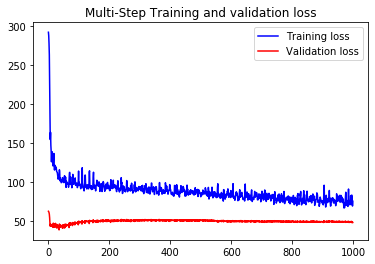

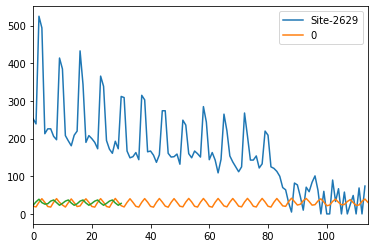

In [30]:
site='Site-2629'
plot_train_history(history, 'Multi-Step Training and validation loss')
plot_forecast_scene_1(model ,sites_visit_data_scene_1[site],site, window_size,target_size)
pred = p_day_forecast_scene_1(model,sites_visit_data_scene_1[site],site,window_size, target_size)
# print(pred)
pred['Value'].plot()
pred.to_csv( base_dir + r'/prediction/'+site+'visit_forcast_1.csv',index=False)

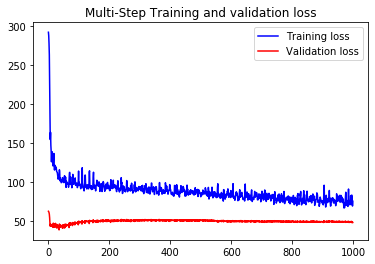

In [31]:
plot_train_history(history, 'Multi-Step Training and validation loss')

In [20]:
site='Site-5298'
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.GRU(128,
                     dropout=0.2,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, 1)))
model.add(tf.keras.layers.GRU(128,
                              return_sequences=True,
                     dropout=0.2,
                     recurrent_dropout=0.5
                     ))
model.add(tf.keras.layers.GRU(128,
                     dropout=0.2,
                     recurrent_dropout=0.5,
                              activation='relu'
                     ))
model.add(tf.keras.layers.Dense(target_size, activation = 'relu'))
history = train_model( model , sites_visit_train_dataset_scene_1[site], 
                             sites_visit_validation_dataset_scene_1[site], 1000,100,100)

Epoch 1/1000
1/1 [==============================] - 7s 7s/step - loss: 291.7012 - val_loss: 0.0000e+00
Epoch 2/1000
1/1 [==============================] - 0s 88ms/step - loss: 287.3508 - val_loss: 62.1840
Epoch 3/1000
1/1 [==============================] - 0s 94ms/step - loss: 277.1305 - val_loss: 61.0235
Epoch 4/1000
1/1 [==============================] - 0s 97ms/step - loss: 262.7926 - val_loss: 58.9200
Epoch 5/1000
1/1 [==============================] - 0s 99ms/step - loss: 230.2034 - val_loss: 54.4784
Epoch 6/1000
1/1 [==============================] - 0s 103ms/step - loss: 197.8975 - val_loss: 47.3488
Epoch 7/1000
1/1 [==============================] - 0s 93ms/step - loss: 154.4797 - val_loss: 43.6574
Epoch 8/1000
1/1 [==============================] - 0s 91ms/step - loss: 163.6784 - val_loss: 46.5785
Epoch 9/1000
1/1 [==============================] - 0s 96ms/step - loss: 147.1548 - val_loss: 44.2965
Epoch 10/1000
1/1 [==============================] - 0s 93ms/step - loss: 139.54

Epoch 81/1000
1/1 [==============================] - 0s 87ms/step - loss: 109.9727 - val_loss: 48.4205
Epoch 82/1000
1/1 [==============================] - 0s 84ms/step - loss: 102.8915 - val_loss: 46.9348
Epoch 83/1000
1/1 [==============================] - 0s 89ms/step - loss: 97.3119 - val_loss: 47.9010
Epoch 84/1000
1/1 [==============================] - 0s 119ms/step - loss: 102.7869 - val_loss: 46.7955
Epoch 85/1000
1/1 [==============================] - 0s 98ms/step - loss: 97.7284 - val_loss: 47.9295
Epoch 86/1000
1/1 [==============================] - 0s 92ms/step - loss: 99.0553 - val_loss: 45.7472
Epoch 87/1000
1/1 [==============================] - 0s 75ms/step - loss: 100.2274 - val_loss: 48.8510
Epoch 88/1000
1/1 [==============================] - 0s 77ms/step - loss: 104.5674 - val_loss: 45.5681
Epoch 89/1000
1/1 [==============================] - 0s 74ms/step - loss: 105.4318 - val_loss: 48.7370
Epoch 90/1000
1/1 [==============================] - 0s 79ms/step - loss: 9

Epoch 161/1000
1/1 [==============================] - 0s 91ms/step - loss: 98.8778 - val_loss: 49.0522
Epoch 162/1000
1/1 [==============================] - 0s 92ms/step - loss: 95.8697 - val_loss: 51.2868
Epoch 163/1000
1/1 [==============================] - 0s 85ms/step - loss: 98.9029 - val_loss: 49.1064
Epoch 164/1000
1/1 [==============================] - 0s 87ms/step - loss: 96.1645 - val_loss: 50.9849
Epoch 165/1000
1/1 [==============================] - 0s 95ms/step - loss: 94.6649 - val_loss: 49.1973
Epoch 166/1000
1/1 [==============================] - 0s 94ms/step - loss: 97.8950 - val_loss: 50.9494
Epoch 167/1000
1/1 [==============================] - 0s 98ms/step - loss: 100.4091 - val_loss: 49.5552
Epoch 168/1000
1/1 [==============================] - 0s 91ms/step - loss: 94.8876 - val_loss: 50.7116
Epoch 169/1000
1/1 [==============================] - 0s 96ms/step - loss: 95.8026 - val_loss: 50.3931
Epoch 170/1000
1/1 [==============================] - 0s 83ms/step - los

Epoch 241/1000
1/1 [==============================] - 0s 99ms/step - loss: 97.7956 - val_loss: 50.4685
Epoch 242/1000
1/1 [==============================] - 0s 88ms/step - loss: 99.5002 - val_loss: 52.1207
Epoch 243/1000
1/1 [==============================] - 0s 92ms/step - loss: 91.8321 - val_loss: 51.0135
Epoch 244/1000
1/1 [==============================] - 0s 94ms/step - loss: 85.5288 - val_loss: 51.4311
Epoch 245/1000
1/1 [==============================] - 0s 97ms/step - loss: 86.4402 - val_loss: 50.5108
Epoch 246/1000
1/1 [==============================] - 0s 86ms/step - loss: 91.7914 - val_loss: 51.7137
Epoch 247/1000
1/1 [==============================] - 0s 92ms/step - loss: 95.2209 - val_loss: 50.4406
Epoch 248/1000
1/1 [==============================] - 0s 101ms/step - loss: 94.0089 - val_loss: 51.9358
Epoch 249/1000
1/1 [==============================] - 0s 87ms/step - loss: 92.7035 - val_loss: 50.5673
Epoch 250/1000
1/1 [==============================] - 0s 98ms/step - los

Epoch 321/1000
1/1 [==============================] - 0s 85ms/step - loss: 98.0424 - val_loss: 51.8877
Epoch 322/1000
1/1 [==============================] - 0s 82ms/step - loss: 90.5089 - val_loss: 50.9676
Epoch 323/1000
1/1 [==============================] - 0s 98ms/step - loss: 86.7846 - val_loss: 51.7766
Epoch 324/1000
1/1 [==============================] - 0s 92ms/step - loss: 91.0126 - val_loss: 50.9139
Epoch 325/1000
1/1 [==============================] - 0s 76ms/step - loss: 92.6179 - val_loss: 51.8829
Epoch 326/1000
1/1 [==============================] - 0s 82ms/step - loss: 92.2175 - val_loss: 50.5473
Epoch 327/1000
1/1 [==============================] - 0s 81ms/step - loss: 89.5128 - val_loss: 52.0179
Epoch 328/1000
1/1 [==============================] - 0s 81ms/step - loss: 85.9716 - val_loss: 50.9592
Epoch 329/1000
1/1 [==============================] - 0s 83ms/step - loss: 89.8877 - val_loss: 52.0421
Epoch 330/1000
1/1 [==============================] - 0s 93ms/step - loss

Epoch 401/1000
1/1 [==============================] - 0s 93ms/step - loss: 91.2037 - val_loss: 51.7094
Epoch 402/1000
1/1 [==============================] - 0s 87ms/step - loss: 90.5200 - val_loss: 50.8250
Epoch 403/1000
1/1 [==============================] - 0s 90ms/step - loss: 87.4155 - val_loss: 51.5915
Epoch 404/1000
1/1 [==============================] - 0s 94ms/step - loss: 84.7086 - val_loss: 50.8882
Epoch 405/1000
1/1 [==============================] - 0s 90ms/step - loss: 85.1232 - val_loss: 51.4524
Epoch 406/1000
1/1 [==============================] - 0s 89ms/step - loss: 84.7018 - val_loss: 50.9307
Epoch 407/1000
1/1 [==============================] - 0s 94ms/step - loss: 83.9911 - val_loss: 51.0671
Epoch 408/1000
1/1 [==============================] - 0s 91ms/step - loss: 87.1218 - val_loss: 51.3133
Epoch 409/1000
1/1 [==============================] - 0s 88ms/step - loss: 85.1029 - val_loss: 51.1109
Epoch 410/1000
1/1 [==============================] - 0s 88ms/step - loss

Epoch 481/1000
1/1 [==============================] - 0s 86ms/step - loss: 84.9180 - val_loss: 51.6284
Epoch 482/1000
1/1 [==============================] - 0s 112ms/step - loss: 90.0264 - val_loss: 50.0661
Epoch 483/1000
1/1 [==============================] - 0s 118ms/step - loss: 92.9899 - val_loss: 51.6364
Epoch 484/1000
1/1 [==============================] - 0s 105ms/step - loss: 84.6164 - val_loss: 50.5975
Epoch 485/1000
1/1 [==============================] - 0s 90ms/step - loss: 86.5207 - val_loss: 51.3263
Epoch 486/1000
1/1 [==============================] - 0s 82ms/step - loss: 88.2718 - val_loss: 50.4374
Epoch 487/1000
1/1 [==============================] - 0s 91ms/step - loss: 89.1859 - val_loss: 51.8288
Epoch 488/1000
1/1 [==============================] - 0s 95ms/step - loss: 90.3032 - val_loss: 50.6422
Epoch 489/1000
1/1 [==============================] - 0s 116ms/step - loss: 87.8448 - val_loss: 51.7100
Epoch 490/1000
1/1 [==============================] - 0s 117ms/step -

Epoch 561/1000
1/1 [==============================] - 0s 89ms/step - loss: 84.6824 - val_loss: 49.6112
Epoch 562/1000
1/1 [==============================] - 0s 87ms/step - loss: 80.9598 - val_loss: 50.4101
Epoch 563/1000
1/1 [==============================] - 0s 90ms/step - loss: 80.5542 - val_loss: 49.7924
Epoch 564/1000
1/1 [==============================] - 0s 84ms/step - loss: 82.8695 - val_loss: 50.8065
Epoch 565/1000
1/1 [==============================] - 0s 94ms/step - loss: 79.4825 - val_loss: 49.9072
Epoch 566/1000
1/1 [==============================] - 0s 121ms/step - loss: 84.3260 - val_loss: 50.5564
Epoch 567/1000
1/1 [==============================] - 0s 124ms/step - loss: 82.7611 - val_loss: 50.0878
Epoch 568/1000
1/1 [==============================] - 0s 105ms/step - loss: 84.1704 - val_loss: 51.0572
Epoch 569/1000
1/1 [==============================] - 0s 87ms/step - loss: 86.7684 - val_loss: 49.5026
Epoch 570/1000
1/1 [==============================] - 0s 110ms/step - 

Epoch 641/1000
1/1 [==============================] - 0s 102ms/step - loss: 78.6477 - val_loss: 49.7279
Epoch 642/1000
1/1 [==============================] - 0s 97ms/step - loss: 78.0812 - val_loss: 50.1923
Epoch 643/1000
1/1 [==============================] - 0s 85ms/step - loss: 79.7179 - val_loss: 50.0896
Epoch 644/1000
1/1 [==============================] - 0s 88ms/step - loss: 79.8732 - val_loss: 49.8726
Epoch 645/1000
1/1 [==============================] - 0s 87ms/step - loss: 75.8928 - val_loss: 49.2149
Epoch 646/1000
1/1 [==============================] - 0s 89ms/step - loss: 81.6908 - val_loss: 50.8349
Epoch 647/1000
1/1 [==============================] - 0s 90ms/step - loss: 97.6323 - val_loss: 49.2220
Epoch 648/1000
1/1 [==============================] - 0s 86ms/step - loss: 80.3270 - val_loss: 50.3229
Epoch 649/1000
1/1 [==============================] - 0s 85ms/step - loss: 82.4822 - val_loss: 49.4173
Epoch 650/1000
1/1 [==============================] - 0s 86ms/step - los

Epoch 721/1000
1/1 [==============================] - 0s 92ms/step - loss: 80.5592 - val_loss: 50.4885
Epoch 722/1000
1/1 [==============================] - 0s 89ms/step - loss: 80.1556 - val_loss: 49.3620
Epoch 723/1000
1/1 [==============================] - 0s 87ms/step - loss: 78.0800 - val_loss: 50.5490
Epoch 724/1000
1/1 [==============================] - 0s 91ms/step - loss: 84.7651 - val_loss: 49.4396
Epoch 725/1000
1/1 [==============================] - 0s 91ms/step - loss: 85.7114 - val_loss: 50.5541
Epoch 726/1000
1/1 [==============================] - 0s 78ms/step - loss: 80.5701 - val_loss: 49.3057
Epoch 727/1000
1/1 [==============================] - 0s 75ms/step - loss: 80.1301 - val_loss: 50.5057
Epoch 728/1000
1/1 [==============================] - 0s 77ms/step - loss: 83.4041 - val_loss: 49.3808
Epoch 729/1000
1/1 [==============================] - 0s 78ms/step - loss: 80.0469 - val_loss: 50.2788
Epoch 730/1000
1/1 [==============================] - 0s 77ms/step - loss

Epoch 801/1000
1/1 [==============================] - 0s 92ms/step - loss: 74.3970 - val_loss: 50.2031
Epoch 802/1000
1/1 [==============================] - 0s 93ms/step - loss: 76.1106 - val_loss: 49.5373
Epoch 803/1000
1/1 [==============================] - 0s 90ms/step - loss: 75.0910 - val_loss: 50.1510
Epoch 804/1000
1/1 [==============================] - 0s 84ms/step - loss: 79.7820 - val_loss: 49.1001
Epoch 805/1000
1/1 [==============================] - 0s 91ms/step - loss: 82.9904 - val_loss: 50.2395
Epoch 806/1000
1/1 [==============================] - 0s 89ms/step - loss: 79.0784 - val_loss: 48.9291
Epoch 807/1000
1/1 [==============================] - 0s 91ms/step - loss: 78.7150 - val_loss: 49.6748
Epoch 808/1000
1/1 [==============================] - 0s 90ms/step - loss: 71.2753 - val_loss: 49.0154
Epoch 809/1000
1/1 [==============================] - 0s 91ms/step - loss: 78.6315 - val_loss: 49.6708
Epoch 810/1000
1/1 [==============================] - 0s 85ms/step - loss

Epoch 881/1000
1/1 [==============================] - 0s 90ms/step - loss: 79.0333 - val_loss: 50.0932
Epoch 882/1000
1/1 [==============================] - 0s 95ms/step - loss: 86.3248 - val_loss: 48.7245
Epoch 883/1000
1/1 [==============================] - 0s 89ms/step - loss: 84.2583 - val_loss: 50.1891
Epoch 884/1000
1/1 [==============================] - 0s 85ms/step - loss: 84.0500 - val_loss: 48.9765
Epoch 885/1000
1/1 [==============================] - 0s 87ms/step - loss: 74.4590 - val_loss: 49.5928
Epoch 886/1000
1/1 [==============================] - 0s 92ms/step - loss: 74.3992 - val_loss: 49.1302
Epoch 887/1000
1/1 [==============================] - 0s 93ms/step - loss: 74.5741 - val_loss: 49.7067
Epoch 888/1000
1/1 [==============================] - 0s 87ms/step - loss: 74.2460 - val_loss: 49.0580
Epoch 889/1000
1/1 [==============================] - 0s 94ms/step - loss: 77.1049 - val_loss: 49.6945
Epoch 890/1000
1/1 [==============================] - 0s 89ms/step - loss

Epoch 961/1000
1/1 [==============================] - 0s 83ms/step - loss: 83.0924 - val_loss: 48.9778
Epoch 962/1000
1/1 [==============================] - 0s 82ms/step - loss: 75.2822 - val_loss: 49.5580
Epoch 963/1000
1/1 [==============================] - 0s 79ms/step - loss: 76.0861 - val_loss: 48.8773
Epoch 964/1000
1/1 [==============================] - 0s 87ms/step - loss: 76.7066 - val_loss: 49.8497
Epoch 965/1000
1/1 [==============================] - 0s 83ms/step - loss: 80.7885 - val_loss: 48.8659
Epoch 966/1000
1/1 [==============================] - 0s 86ms/step - loss: 73.9079 - val_loss: 49.7566
Epoch 967/1000
1/1 [==============================] - 0s 84ms/step - loss: 77.3668 - val_loss: 48.6885
Epoch 968/1000
1/1 [==============================] - 0s 81ms/step - loss: 77.9553 - val_loss: 49.7679
Epoch 969/1000
1/1 [==============================] - 0s 84ms/step - loss: 78.5014 - val_loss: 48.9171
Epoch 970/1000
1/1 [==============================] - 0s 99ms/step - loss

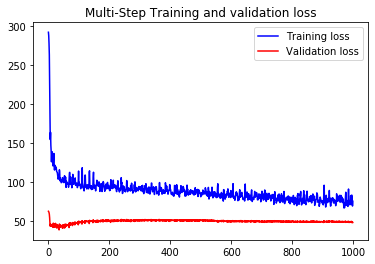

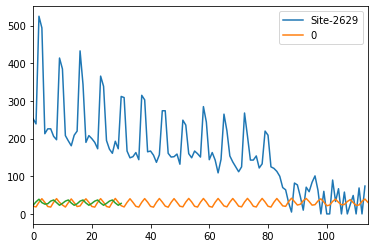

In [33]:
# site='Site-5298'
plot_train_history(history, 'Multi-Step Training and validation loss')
plot_forecast_scene_1(model ,sites_visit_data_scene_1[site],site, window_size,target_size)
pred = p_day_forecast_scene_1(model,sites_visit_data_schttps://www.topcoder.com/challenges/30104412?tab=registrantsene_1[site],site,window_size, target_size)
# print(pred)
pred['Value'].plot()
pred.to_csv( base_dir + r'/prediction/'+site+'visit_forcast_1.csv',index=False)

In [116]:
pred.to_csv( base_dir + r'/prediction/'+site+'_forcast_2.csv',index=False)

In [50]:
site_2629_forcast_1=p_day_forecast_scene_1(model_2629, site_2629_meeting_data,'Site_2629', window_size, target_size)
site_2629_forcast_1
site_2629_forcast_1.to_csv( base_dir + r'/prediction/site_2629_forcast_1.csv',index=False)

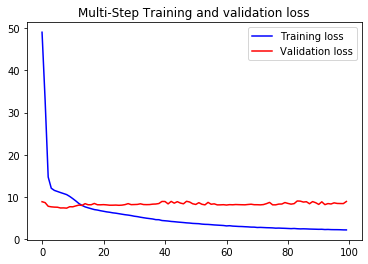

In [124]:
plot_train_history(history, 'Multi-Step Training and validation loss')

<p style="font-family: Arial; font-size:1.25em;color:#2462C0; font-style:bold">
Building and Training Model for Scenerio 2</p>

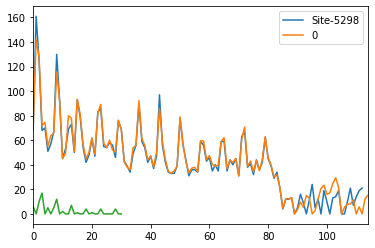

In [125]:
# for site in PRED_SITES:
plot_forecast_scene_2(model ,sites_meeting_data[site],site, window_size,target_size)
pred = p_day_forecast_scene_2(model,sites_meeting_data[site],site,window_size, target_size)
# print(pred)
pred['Value'].plot()


In [116]:

pred.to_csv( base_dir + r'/prediction/'+site+'_forcast_2.csv',index=False)

In [61]:
def p_day_forecast_scene_2(model, data, site, window_size, target_size):
    last_date=data.index[-1]
    p_day = datetime(2022, 7, 15)
    delta = p_day-last_date
    x = data.values[-window_size:]
    for time in range (0, 30 + delta.days,target_size):
        pred = model.predict(x[np.newaxis, time:time+window_size].astype(np.float32)) 
        pred = pred.reshape((target_size,1))
        pred=np.rint(pred)
        y = np.empty((target_size, x.shape[1]))
        y[:,0:1]=pred
        y[:,1:]=0
        x = np.concatenate([x, y], axis=0)
    
    index=pd.date_range(data.index[-window_size], periods=x.shape[0])
    x=pd.DataFrame(x[:,0],index=index,columns=['Value'])
    x.index.rename('Timestep',inplace=True)
    x = x[p_day:p_day+timedelta(30)]
    x['Scenario']='Scenario 2'
    x['Site'] = site
    x = x.reset_index()
    x=x[['Scenario','Site','Timestep','Value']]
    return x


# p_day_forecast_scene_2(model,sites_meeting_data['Site-2629'],'Site-2629',window_size, target_size)

In [69]:
def plot_forecast_scene_2(model, data, site, window_size,target_size):
    forecast = []
    values=data.values
    for time in range(0, len(values) - window_size,target_size):
        x=values[time:time + window_size][np.newaxis].astype(np.float32)
        pred = model.predict(x)
        pred = pred.reshape(target_size)
        forecast.append(pred)
    forecast = np.array(forecast).reshape(-1)
    res = pd.concat([data[window_size:].reset_index()[site], pd.DataFrame(forecast)], axis =1)
    res.plot()

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold">
Predict Test Question 2</p> 

<p style="font-family: Arial; font-size:1.25em;color:#2462C0; font-style:bold">
Data preprocessing</p>

The function below returns a dataset of number of daily meeting for a specific site.

In [5]:
def get_meeting_data(data, site_id):
    meeting_data = data[data['VariableName']=='OngoingMeetingId']
    meeting_data = meeting_data[meeting_data['EntityIdx']==site_id]
    if meeting_data.empty == True:
        return pd.DataFrame()
    meeting_data = meeting_data.groupby('Value')['Timestep'].min().reset_index()
    meeting_data = meeting_data.groupby('Timestep')[['Value']].count()
    meeting_data.rename(columns={'Value':site_id}, 
                 inplace=True)
    meeting_data.index = pd.to_datetime(meeting_data.index)
    meeting_data =  meeting_data.resample('D').sum()
    return meeting_data

Meeting data is extracted from the two given initial data packages and concatenated.

In [6]:
site_2629_meeting_data_1 = get_meeting_data(initial_data_1, 'Site-2629')
site_5298_meeting_data_1 = get_meeting_data(initial_data_1, 'Site-5298')
site_5299_meeting_data_1 = get_meeting_data(initial_data_1, 'Site-5299')
site_10648_meeting_data_1 = get_meeting_data(initial_data_1, 'Site-10648')
site_7976_meeting_data_1 = get_meeting_data(initial_data_1, 'Site-7976')

site_2629_meeting_data_2 = get_meeting_data(initial_data_2, 'Site-2629')
site_5298_meeting_data_2 = get_meeting_data(initial_data_2, 'Site-5298')
site_5299_meeting_data_2 = get_meeting_data(initial_data_2, 'Site-5299')
site_10648_meeting_data_2 = get_meeting_data(initial_data_2, 'Site-10648')
site_7976_meeting_data_2 = get_meeting_data(initial_data_2, 'Site-7976')

site_2629_meeting_data =  pd.concat([site_2629_meeting_data_1, site_2629_meeting_data_2])
site_5298_meeting_data =  pd.concat([site_5298_meeting_data_1, site_5298_meeting_data_2])
site_5299_meeting_data =  pd.concat([site_5299_meeting_data_1, site_5299_meeting_data_2])
site_10648_meeting_data =  pd.concat([site_10648_meeting_data_1, site_10648_meeting_data_2])
site_7976_meeting_data =  pd.concat([site_7976_meeting_data_1, site_7976_meeting_data_2])

Let's plot data of Site-2629.

,Site-2629
Timestep,
2019-08-01,34
2019-08-02,38
2019-08-03,64
2019-08-04,53
2019-08-05,18
...,...
2022-07-09,8
2022-07-10,0
2022-07-11,16


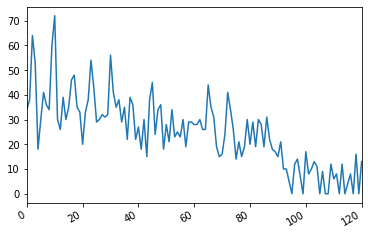

In [7]:
site_2629_meeting_data.reset_index()['Site-2629'].plot(subplots=True)                   
site_2629_meeting_data

Now we have to divide data into features and labels. For time series data features are previous obeserved values and label is the value to be predicted. Here, the number of features is called window size and a slice of the time series of length equal to window size is called a window. The following function creates a windowed dataset from the given time series. Here target_size is the number of future predicted values.

In [32]:
def windowed_data(dataframe, window_size, target_size, batch_size,shuffle=True, repeat= True):
    dataset = tf.data.Dataset.from_tensor_slices(dataframe)
    dataset = dataset.window(window_size+target_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+target_size))
    dataset = dataset.shuffle(1000)
    dataset = dataset.map(lambda window: (window[:-target_size],window[-target_size:]))
    dataset = dataset.batch(batch_size)
    if repeat:
        dataset = dataset.repeat()
    return dataset

We have to split the data into train and validation set. We set training data size to 90. the rest of the data will be used for validation. Window size is set to 8 and future target size is set to 5.

In [33]:
TRAIN_SPLIT = 100
BATCH_SIZE = 100
window_size = 7
target_size = 5

In [34]:
site_2629_meeting_values = site_2629_meeting_data.values
site_5298_meeting_values = site_5298_meeting_data.values
site_5299_meeting_values = site_5299_meeting_data.values
site_10648_meeting_values = site_10648_meeting_data.values
site_7976_meeting_values = site_7976_meeting_data.values

site_2629_train_dataset = windowed_data(site_2629_meeting_values[:TRAIN_SPLIT], window_size, target_size, BATCH_SIZE)
site_2629_validation_dataset = windowed_data(site_2629_meeting_values[TRAIN_SPLIT:], window_size, target_size, BATCH_SIZE)


site_5298_train_dataset = windowed_data(site_5298_meeting_values[:TRAIN_SPLIT], window_size, target_size, BATCH_SIZE)
site_5298_validation_dataset = windowed_data(site_5298_meeting_values[TRAIN_SPLIT:], window_size, target_size, BATCH_SIZE)

site_5299_train_dataset = windowed_data(site_5299_meeting_values[:TRAIN_SPLIT], window_size, target_size, BATCH_SIZE)
site_5299_validation_dataset = windowed_data(site_5299_meeting_values[TRAIN_SPLIT:], window_size, target_size, BATCH_SIZE)

site_10648_train_dataset = windowed_data(site_10648_meeting_values[:TRAIN_SPLIT], window_size, target_size, BATCH_SIZE)
site_10648_validation_dataset = windowed_data(site_10648_meeting_values[TRAIN_SPLIT:], window_size, target_size, BATCH_SIZE)

site_7976_train_dataset = windowed_data(site_7976_meeting_values[:TRAIN_SPLIT], window_size, target_size, BATCH_SIZE)
site_7976_validation_dataset = windowed_data(site_7976_meeting_values[TRAIN_SPLIT:], window_size, target_size, BATCH_SIZE)

for x, y in site_2629_train_dataset.take(1):
    print('x=',x.shape, 'y=',y.shape)
   

x= (89, 7, 1) y= (89, 5, 1)


<p style="font-family: Arial; font-size:1.25em;color:#2462C0; font-style:bold">
Building and Training Model for Scenerio 1</p>

In [ ]:
tf.keras.backend.clear_session()
model_2629 = tf.keras.models.Sequential()
model_2629.add(tf.keras.layers.GRU(64,
#                      dropout=0.1,
                     return_sequences=True,
                     input_shape=(None, 1)))
model_2629.add(tf.keras.layers.GRU(64, activation='relu'
#                      dropout=0.1
                                  ))
model_2629.add(tf.keras.layers.Dense(target_size,  activation='relu' ))


model_2629.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
history_2629 = model_2629.fit(site_2629_train_dataset,
                              steps_per_epoch=200,
                              epochs=800,
                              validation_data=site_2629_validation_dataset,
                              validation_steps=200
                             )


Train for 200 steps, validate for 200 steps
Epoch 1/800
200/200 [==============================] - 6s 30ms/step - loss: 16.0600 - val_loss: 5.3269
Epoch 2/800
200/200 [==============================] - 3s 17ms/step - loss: 11.3487 - val_loss: 4.9104
Epoch 3/800
200/200 [==============================] - 4s 18ms/step - loss: 10.1164 - val_loss: 4.8733
Epoch 4/800
200/200 [==============================] - 3s 16ms/step - loss: 9.4868 - val_loss: 5.8698
Epoch 5/800
200/200 [==============================] - 3s 17ms/step - loss: 8.8334 - val_loss: 5.4611
Epoch 6/800
200/200 [==============================] - 3s 16ms/step - loss: 8.3106 - val_loss: 5.7524
Epoch 7/800
200/200 [==============================] - 3s 16ms/step - loss: 7.8873 - val_loss: 5.8915
Epoch 8/800
200/200 [==============================] - 3s 16ms/step - loss: 7.5332 - val_loss: 5.6460
Epoch 9/800
200/200 [==============================] - 3s 16ms/step - loss: 7.2442 - val_loss: 5.6849
Epoch 10/800
200/200 [=============

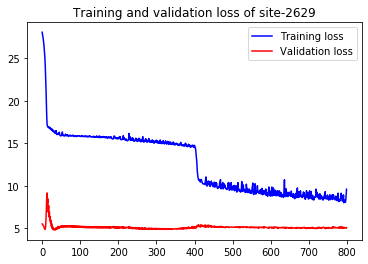

In [35]:
plot_train_history(history_2629, 'Training and validation loss of site-2629')

Now we can make prediction for next 30 days after p-day by using the below function.

In [19]:
site_2629_forcast_1=p_day_forecast_scene_1(model_2629, site_2629_meeting_data,'Site_2629', window_size, target_size)
site_2629_forcast_1
site_2629_forcast_1.to_csv( base_dir + r'/prediction/site_2629_forcast_1.csv',index=False)

In [ ]:
def plot_forecast(model, data, site, window_size,target_size):
    forecast = []
    values=data.values
    for time in range(0, len(values) - window_size,target_size):
        pred = model.predict(values[time:time + window_size][np.newaxis].astype(np.float32))
        pred = pred.reshape(target_size)
        forecast.append(pred)
    forecast = np.array(forecast).reshape(-1)
    res = pd.concat([data[window_size:].reset_index()[site], pd.DataFrame(forecast)], axis =1)
    res.plot()

[ 0.        35.63281   63.843513  62.867336  30.485748   0.
 36.889423  34.40675   35.37522   46.687122   0.        37.137817
 29.533495  31.221785  34.03589    0.        51.564632  49.1359
 32.46796   31.84291    0.        31.636274  39.639988  50.027798
 41.53132    0.        37.077927  32.607704  29.402393  30.724957
  0.        39.376698  36.84411   30.404118  29.404568   0.
 22.91232   33.83136   42.52088   24.140093   0.        38.869244
 24.208418  30.341675  23.401834   0.        27.67093   25.379078
 27.922361  29.480549   0.        31.490665  28.957842  29.679873
 27.9167     0.        26.524857  26.06254   35.422234  35.341713
  0.        35.733967  29.29602   25.341448  26.467386   0.
 36.25575   29.029093  16.046553  23.55765    0.        23.04186
 37.484123  22.481318  30.319595   0.        28.216381  24.497658
 23.090075  34.424747   0.        22.458794  17.279324  17.935722
 22.319544   0.        11.877374   9.336696   0.        12.625281
  0.        10.011906  17.93011

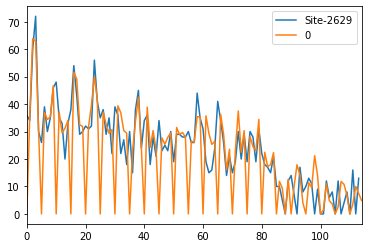

In [26]:
plot_forecast_scene_1(model_2629 ,site_2629_meeting_data,'Site-2629', window_size,target_size)

Model for site-5298

In [67]:
tf.keras.backend.clear_session()
model_5298 = tf.keras.models.Sequential()
model_5298.add(tf.keras.layers.GRU(128,
                     dropout=0.01,
                     recurrent_dropout=0.01,
                     return_sequences=True,
                     input_shape=(None, 1)))
model_5298.add(tf.keras.layers.GRU(128,
                     dropout=0.01,
                     recurrent_dropout=0.01,
                     activation='relu'))
model_5298.add(tf.keras.layers.Dense(target_size,  activation='relu' ))


model_5298.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
history_5298 = model_5298.fit_generator(site_5298_train_dataset,
#                               steps_per_epoch=200,
                              epochs=600,
                              validation_data=site_5298_validation_dataset,
#                               validation_steps=200
                             )

Epoch 1/600
2/2 [==============================] - 0s 115ms/step - loss: 50.6328 - val_loss: 0.0000e+00
Epoch 2/600
2/2 [==============================] - 0s 107ms/step - loss: 48.3555 - val_loss: 8.4081
Epoch 3/600
2/2 [==============================] - 0s 105ms/step - loss: 40.6688 - val_loss: 15.5921
Epoch 4/600
2/2 [==============================] - 0s 114ms/step - loss: 28.5654 - val_loss: 9.1758
Epoch 5/600
2/2 [==============================] - 0s 107ms/step - loss: 26.7208 - val_loss: 10.6191
Epoch 6/600
2/2 [==============================] - 0s 105ms/step - loss: 24.3223 - val_loss: 8.9192
Epoch 7/600
2/2 [==============================] - 0s 111ms/step - loss: 24.5702 - val_loss: 7.6820
Epoch 8/600
2/2 [==============================] - 0s 106ms/step - loss: 23.6031 - val_loss: 7.7438
Epoch 9/600
2/2 [==============================] - 0s 111ms/step - loss: 23.5464 - val_loss: 7.6839
Epoch 10/600
2/2 [==============================] - 0s 161ms/step - loss: 24.7033 - val_loss: 

Epoch 82/600
2/2 [==============================] - 0s 100ms/step - loss: 22.7590 - val_loss: 9.8954
Epoch 83/600
2/2 [==============================] - 0s 101ms/step - loss: 22.1159 - val_loss: 9.6611
Epoch 84/600
2/2 [==============================] - 0s 99ms/step - loss: 21.4801 - val_loss: 9.4749
Epoch 85/600
2/2 [==============================] - 0s 99ms/step - loss: 21.6662 - val_loss: 9.5665
Epoch 86/600
2/2 [==============================] - 0s 100ms/step - loss: 21.1074 - val_loss: 9.3843
Epoch 87/600
2/2 [==============================] - 0s 100ms/step - loss: 21.3201 - val_loss: 9.3251
Epoch 88/600
2/2 [==============================] - 0s 100ms/step - loss: 20.9136 - val_loss: 9.6202
Epoch 89/600
2/2 [==============================] - 0s 102ms/step - loss: 20.9696 - val_loss: 9.4236
Epoch 90/600
2/2 [==============================] - 0s 98ms/step - loss: 20.9662 - val_loss: 9.4319
Epoch 91/600
2/2 [==============================] - 0s 99ms/step - loss: 21.5487 - val_loss: 9

Epoch 163/600
2/2 [==============================] - 0s 101ms/step - loss: 9.8215 - val_loss: 8.8263
Epoch 164/600
2/2 [==============================] - 0s 99ms/step - loss: 11.8667 - val_loss: 8.7552
Epoch 165/600
2/2 [==============================] - 0s 99ms/step - loss: 12.0925 - val_loss: 8.8150
Epoch 166/600
2/2 [==============================] - 0s 103ms/step - loss: 9.8426 - val_loss: 8.6135
Epoch 167/600
2/2 [==============================] - 0s 100ms/step - loss: 9.5819 - val_loss: 8.7184
Epoch 168/600
2/2 [==============================] - 0s 101ms/step - loss: 9.8264 - val_loss: 8.8968
Epoch 169/600
2/2 [==============================] - 0s 99ms/step - loss: 11.4148 - val_loss: 8.8392
Epoch 170/600
2/2 [==============================] - 0s 99ms/step - loss: 12.4084 - val_loss: 8.8086
Epoch 171/600
2/2 [==============================] - 0s 99ms/step - loss: 10.6874 - val_loss: 8.7625
Epoch 172/600
2/2 [==============================] - 0s 97ms/step - loss: 10.7842 - val_los

2/2 [==============================] - 0s 100ms/step - loss: 7.6261 - val_loss: 8.4596
Epoch 326/600
2/2 [==============================] - 0s 100ms/step - loss: 11.0755 - val_loss: 8.5227
Epoch 327/600
2/2 [==============================] - 0s 98ms/step - loss: 7.2055 - val_loss: 8.5308
Epoch 328/600
2/2 [==============================] - 0s 101ms/step - loss: 6.6631 - val_loss: 8.6647
Epoch 329/600
2/2 [==============================] - 0s 100ms/step - loss: 7.0184 - val_loss: 8.5124
Epoch 330/600
2/2 [==============================] - 0s 100ms/step - loss: 8.8658 - val_loss: 8.6538
Epoch 331/600
2/2 [==============================] - 0s 100ms/step - loss: 10.3309 - val_loss: 8.5653
Epoch 332/600
2/2 [==============================] - 0s 99ms/step - loss: 7.6967 - val_loss: 8.6218
Epoch 333/600
2/2 [==============================] - 0s 99ms/step - loss: 7.9556 - val_loss: 8.7751
Epoch 334/600
2/2 [==============================] - 0s 105ms/step - loss: 6.4077 - val_loss: 8.7100
Epoch

2/2 [==============================] - 0s 99ms/step - loss: 6.4979 - val_loss: 9.0957
Epoch 488/600
2/2 [==============================] - 0s 99ms/step - loss: 6.4132 - val_loss: 8.9926
Epoch 489/600
2/2 [==============================] - 0s 100ms/step - loss: 5.8168 - val_loss: 8.9925
Epoch 490/600
2/2 [==============================] - 0s 101ms/step - loss: 4.9195 - val_loss: 8.9085
Epoch 491/600
2/2 [==============================] - 0s 99ms/step - loss: 5.3042 - val_loss: 8.8417
Epoch 492/600
2/2 [==============================] - 0s 99ms/step - loss: 6.7560 - val_loss: 8.8587
Epoch 493/600
2/2 [==============================] - 0s 100ms/step - loss: 6.7040 - val_loss: 9.2317
Epoch 494/600
2/2 [==============================] - 0s 100ms/step - loss: 6.2596 - val_loss: 8.7563
Epoch 495/600
2/2 [==============================] - 0s 100ms/step - loss: 6.2661 - val_loss: 8.9799
Epoch 496/600
2/2 [==============================] - 0s 98ms/step - loss: 5.2800 - val_loss: 9.0047
Epoch 497

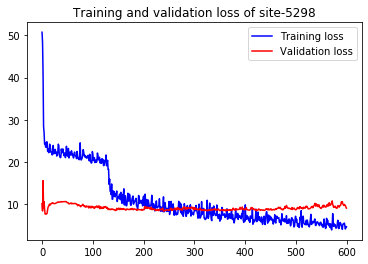

In [68]:
plot_train_history(history_5298, 'Training and validation loss of site-5298')

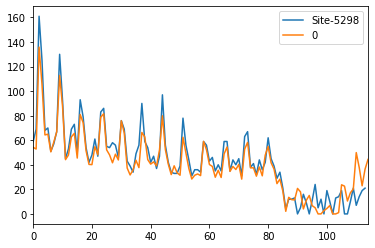

In [69]:
plot_forecast(model_5298 ,site_5298_meeting_data,'Site-5298', window_size,target_size)

In [70]:


site_5298_forcast_1
site_5298_forcast_1.to_csv(base_dir + r'/prediction/site_5298_forcast_1.csv',index=False)

Model of site-5299

In [83]:
tf.keras.backend.clear_session()
model_5299 = tf.keras.models.Sequential()
model_5299.add(tf.keras.layers.GRU(128,
                     dropout=0.1,
#                      recurrent_dropout=0.1,
                     return_sequences=True,
                     input_shape=(None, 1)))
model_5299.add(tf.keras.layers.GRU(64,
                     dropout=0.1,
#                      recurrent_dropout=0.1,
                     activation='relu'))
model_5299.add(tf.keras.layers.Dense(target_size,  activation='relu' ))

model_5299.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
history_5299 = model_5299.fit_generator(site_5299_train_dataset,
                              epochs=600,
                              validation_data=site_5299_validation_dataset,
                             )

Epoch 1/600
2/2 [==============================] - 0s 88ms/step - loss: 19.4646 - val_loss: 0.0000e+00
Epoch 2/600
2/2 [==============================] - 0s 82ms/step - loss: 18.8906 - val_loss: 7.3192
Epoch 3/600
2/2 [==============================] - 0s 85ms/step - loss: 18.0359 - val_loss: 6.3938
Epoch 4/600
2/2 [==============================] - 0s 85ms/step - loss: 16.6630 - val_loss: 6.5975
Epoch 5/600
2/2 [==============================] - 0s 133ms/step - loss: 15.1091 - val_loss: 10.6100
Epoch 6/600
2/2 [==============================] - 0s 103ms/step - loss: 14.5512 - val_loss: 7.9075
Epoch 7/600
2/2 [==============================] - 0s 81ms/step - loss: 13.7510 - val_loss: 9.6713
Epoch 8/600
2/2 [==============================] - 0s 88ms/step - loss: 13.4728 - val_loss: 7.2502
Epoch 9/600
2/2 [==============================] - 0s 85ms/step - loss: 13.2732 - val_loss: 5.9409
Epoch 10/600
2/2 [==============================] - 0s 86ms/step - loss: 13.2344 - val_loss: 7.8593
Ep

Epoch 83/600
2/2 [==============================] - 0s 76ms/step - loss: 11.4638 - val_loss: 5.7433
Epoch 84/600
2/2 [==============================] - 0s 78ms/step - loss: 11.3900 - val_loss: 6.1236
Epoch 85/600
2/2 [==============================] - 0s 77ms/step - loss: 11.1882 - val_loss: 5.7584
Epoch 86/600
2/2 [==============================] - 0s 77ms/step - loss: 11.2462 - val_loss: 6.0761
Epoch 87/600
2/2 [==============================] - 0s 78ms/step - loss: 11.2261 - val_loss: 5.8592
Epoch 88/600
2/2 [==============================] - 0s 78ms/step - loss: 10.9872 - val_loss: 5.7358
Epoch 89/600
2/2 [==============================] - 0s 79ms/step - loss: 10.9126 - val_loss: 5.7775
Epoch 90/600
2/2 [==============================] - 0s 77ms/step - loss: 10.9640 - val_loss: 5.9724
Epoch 91/600
2/2 [==============================] - 0s 77ms/step - loss: 11.8069 - val_loss: 5.8982
Epoch 92/600
2/2 [==============================] - 0s 76ms/step - loss: 11.1053 - val_loss: 5.8869


Epoch 246/600
2/2 [==============================] - 0s 78ms/step - loss: 7.6899 - val_loss: 7.1407
Epoch 247/600
2/2 [==============================] - 0s 79ms/step - loss: 7.8236 - val_loss: 7.0919
Epoch 248/600
2/2 [==============================] - 0s 77ms/step - loss: 7.9274 - val_loss: 6.6974
Epoch 249/600
2/2 [==============================] - 0s 77ms/step - loss: 7.0764 - val_loss: 6.9121
Epoch 250/600
2/2 [==============================] - 0s 77ms/step - loss: 7.4072 - val_loss: 6.9479
Epoch 251/600
2/2 [==============================] - 0s 77ms/step - loss: 7.4870 - val_loss: 6.3504
Epoch 252/600
2/2 [==============================] - 0s 79ms/step - loss: 7.6518 - val_loss: 6.3088
Epoch 253/600
2/2 [==============================] - 0s 77ms/step - loss: 8.1837 - val_loss: 6.8660
Epoch 254/600
2/2 [==============================] - 0s 78ms/step - loss: 7.6909 - val_loss: 7.1293
Epoch 255/600
2/2 [==============================] - 0s 78ms/step - loss: 7.3253 - val_loss: 6.7520


Epoch 328/600
2/2 [==============================] - 0s 80ms/step - loss: 6.9500 - val_loss: 7.3258
Epoch 329/600
2/2 [==============================] - 0s 79ms/step - loss: 6.0795 - val_loss: 7.0970
Epoch 330/600
2/2 [==============================] - 0s 82ms/step - loss: 6.2352 - val_loss: 7.0714
Epoch 331/600
2/2 [==============================] - 0s 78ms/step - loss: 6.8097 - val_loss: 7.0185
Epoch 332/600
2/2 [==============================] - 0s 79ms/step - loss: 6.3389 - val_loss: 6.9172
Epoch 333/600
2/2 [==============================] - 0s 79ms/step - loss: 6.1087 - val_loss: 7.1271
Epoch 334/600
2/2 [==============================] - 0s 79ms/step - loss: 6.6365 - val_loss: 7.3670
Epoch 335/600
2/2 [==============================] - 0s 79ms/step - loss: 5.9229 - val_loss: 7.3130
Epoch 336/600
2/2 [==============================] - 0s 79ms/step - loss: 6.0696 - val_loss: 7.2546
Epoch 337/600
2/2 [==============================] - 0s 78ms/step - loss: 6.3335 - val_loss: 7.2205


Epoch 410/600
2/2 [==============================] - 0s 82ms/step - loss: 5.5906 - val_loss: 7.2784
Epoch 411/600
2/2 [==============================] - 0s 81ms/step - loss: 5.6286 - val_loss: 7.4795
Epoch 412/600
2/2 [==============================] - 0s 78ms/step - loss: 5.4545 - val_loss: 7.2638
Epoch 413/600
2/2 [==============================] - 0s 81ms/step - loss: 5.6165 - val_loss: 7.1620
Epoch 414/600
2/2 [==============================] - 0s 79ms/step - loss: 6.3106 - val_loss: 7.2244
Epoch 415/600
2/2 [==============================] - 0s 78ms/step - loss: 5.1080 - val_loss: 7.0213
Epoch 416/600
2/2 [==============================] - 0s 79ms/step - loss: 5.6175 - val_loss: 7.3924
Epoch 417/600
2/2 [==============================] - 0s 83ms/step - loss: 5.6685 - val_loss: 7.4074
Epoch 418/600
2/2 [==============================] - 0s 83ms/step - loss: 6.2819 - val_loss: 7.3710
Epoch 419/600
2/2 [==============================] - 0s 82ms/step - loss: 5.3729 - val_loss: 7.3396


Epoch 492/600
2/2 [==============================] - 0s 78ms/step - loss: 4.6640 - val_loss: 7.0237
Epoch 493/600
2/2 [==============================] - 0s 79ms/step - loss: 5.0047 - val_loss: 7.4871
Epoch 494/600
2/2 [==============================] - 0s 77ms/step - loss: 5.5618 - val_loss: 7.3579
Epoch 495/600
2/2 [==============================] - 0s 76ms/step - loss: 5.3496 - val_loss: 7.0649
Epoch 496/600
2/2 [==============================] - 0s 83ms/step - loss: 4.7350 - val_loss: 7.1408
Epoch 497/600
2/2 [==============================] - 0s 104ms/step - loss: 5.1035 - val_loss: 7.1253
Epoch 498/600
2/2 [==============================] - 0s 77ms/step - loss: 4.6254 - val_loss: 6.9317
Epoch 499/600
2/2 [==============================] - 0s 78ms/step - loss: 4.4581 - val_loss: 7.1009
Epoch 500/600
2/2 [==============================] - 0s 78ms/step - loss: 5.3549 - val_loss: 7.1681
Epoch 501/600
2/2 [==============================] - 0s 78ms/step - loss: 4.7476 - val_loss: 6.9425

Epoch 574/600
2/2 [==============================] - 0s 79ms/step - loss: 3.9249 - val_loss: 7.2413
Epoch 575/600
2/2 [==============================] - 0s 78ms/step - loss: 4.3332 - val_loss: 7.0739
Epoch 576/600
2/2 [==============================] - 0s 77ms/step - loss: 4.2879 - val_loss: 7.0960
Epoch 577/600
2/2 [==============================] - 0s 78ms/step - loss: 4.1223 - val_loss: 7.1695
Epoch 578/600
2/2 [==============================] - 0s 77ms/step - loss: 4.4378 - val_loss: 6.9746
Epoch 579/600
2/2 [==============================] - 0s 77ms/step - loss: 4.7737 - val_loss: 6.9870
Epoch 580/600
2/2 [==============================] - 0s 78ms/step - loss: 4.7946 - val_loss: 6.9056
Epoch 581/600
2/2 [==============================] - 0s 78ms/step - loss: 4.3984 - val_loss: 6.9772
Epoch 582/600
2/2 [==============================] - 0s 77ms/step - loss: 3.9196 - val_loss: 7.0860
Epoch 583/600
2/2 [==============================] - 0s 77ms/step - loss: 4.5107 - val_loss: 7.3295


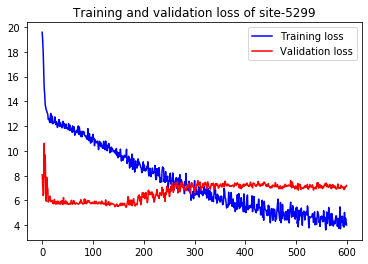

In [85]:
plot_train_history(history_5299, 'Training and validation loss of site-5299')

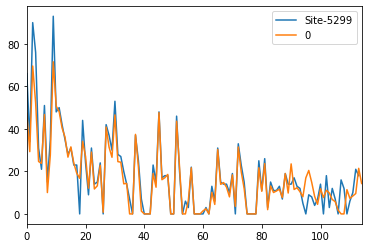

In [86]:
plot_forecast(model_5299 ,site_5299_meeting_data,'Site-5299', window_size,target_size)

In [87]:
site_5299_forcast_1=p_day_forecast(model_5299, site_5299_meeting_data,'Site_5299', window_size, target_size)
site_5299_forcast_1
site_5299_forcast_1.to_csv( base_dir + r'/prediction/site_5299_forcast_1.csv',index=False)

Model of Site-10648

In [100]:
tf.keras.backend.clear_session()
model_10648 = tf.keras.models.Sequential()
model_10648.add(tf.keras.layers.GRU(32,
                     dropout=0.1,
#                      recurrent_dropout=0.1,
                     return_sequences=True,
                     input_shape=(None, 1)))
model_10648.add(tf.keras.layers.GRU(32,
                     dropout=0.1,
#                      recurrent_dropout=0.1,
                     activation='relu'))
model_10648.add(tf.keras.layers.Dense(target_size,  activation='relu' ))


model_10648.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
history_10648 = model_10648.fit_generator(site_10648_train_dataset,
#                               steps_per_epoch=200,
                              epochs=600,
                              validation_data=site_10648_validation_dataset,
#                               validation_steps=200
                             )

Epoch 1/600
2/2 [==============================] - 0s 86ms/step - loss: 18.4308 - val_loss: 0.0000e+00
Epoch 2/600
2/2 [==============================] - 0s 75ms/step - loss: 18.7236 - val_loss: 5.4163
Epoch 3/600
2/2 [==============================] - 0s 76ms/step - loss: 18.5866 - val_loss: 5.4265
Epoch 4/600
2/2 [==============================] - 0s 73ms/step - loss: 18.5142 - val_loss: 5.4357
Epoch 5/600
2/2 [==============================] - 0s 73ms/step - loss: 18.6639 - val_loss: 5.4496
Epoch 6/600
2/2 [==============================] - 0s 76ms/step - loss: 18.4553 - val_loss: 5.4638
Epoch 7/600
2/2 [==============================] - 0s 80ms/step - loss: 18.5103 - val_loss: 5.4777
Epoch 8/600
2/2 [==============================] - 0s 75ms/step - loss: 18.5855 - val_loss: 5.4931
Epoch 9/600
2/2 [==============================] - 0s 76ms/step - loss: 18.5599 - val_loss: 5.5070
Epoch 10/600
2/2 [==============================] - 0s 77ms/step - loss: 18.0345 - val_loss: 5.5305
Epoch

Epoch 83/600
2/2 [==============================] - 0s 71ms/step - loss: 15.4579 - val_loss: 5.5652
Epoch 84/600
2/2 [==============================] - 0s 71ms/step - loss: 15.3220 - val_loss: 5.5714
Epoch 85/600
2/2 [==============================] - 0s 70ms/step - loss: 15.3202 - val_loss: 5.5514
Epoch 86/600
2/2 [==============================] - 0s 71ms/step - loss: 16.0868 - val_loss: 5.5616
Epoch 87/600
2/2 [==============================] - 0s 71ms/step - loss: 16.2472 - val_loss: 5.5575
Epoch 88/600
2/2 [==============================] - 0s 70ms/step - loss: 15.7788 - val_loss: 5.5740
Epoch 89/600
2/2 [==============================] - 0s 70ms/step - loss: 15.9316 - val_loss: 5.5664
Epoch 90/600
2/2 [==============================] - 0s 71ms/step - loss: 15.6904 - val_loss: 5.5839
Epoch 91/600
2/2 [==============================] - 0s 70ms/step - loss: 15.8462 - val_loss: 5.5768
Epoch 92/600
2/2 [==============================] - 0s 71ms/step - loss: 15.8840 - val_loss: 5.5644


2/2 [==============================] - 0s 73ms/step - loss: 12.9068 - val_loss: 6.0997
Epoch 246/600
2/2 [==============================] - 0s 87ms/step - loss: 13.6288 - val_loss: 6.0012
Epoch 247/600
2/2 [==============================] - 0s 102ms/step - loss: 12.7706 - val_loss: 5.9490
Epoch 248/600
2/2 [==============================] - 0s 75ms/step - loss: 12.7761 - val_loss: 6.0713
Epoch 249/600
2/2 [==============================] - 0s 70ms/step - loss: 12.7049 - val_loss: 6.0623
Epoch 250/600
2/2 [==============================] - 0s 68ms/step - loss: 13.0473 - val_loss: 6.0133
Epoch 251/600
2/2 [==============================] - 0s 74ms/step - loss: 13.1333 - val_loss: 5.9381
Epoch 252/600
2/2 [==============================] - 0s 98ms/step - loss: 14.1332 - val_loss: 6.1147
Epoch 253/600
2/2 [==============================] - 0s 95ms/step - loss: 13.3018 - val_loss: 5.9920
Epoch 254/600
2/2 [==============================] - 0s 73ms/step - loss: 13.2644 - val_loss: 6.1604
Epo

2/2 [==============================] - 0s 75ms/step - loss: 11.5920 - val_loss: 6.6831
Epoch 408/600
2/2 [==============================] - 0s 99ms/step - loss: 11.0848 - val_loss: 6.5903
Epoch 409/600
2/2 [==============================] - 0s 91ms/step - loss: 11.1582 - val_loss: 6.7349
Epoch 410/600
2/2 [==============================] - 0s 102ms/step - loss: 11.7528 - val_loss: 6.5330
Epoch 411/600
2/2 [==============================] - 0s 75ms/step - loss: 10.8560 - val_loss: 6.6075
Epoch 412/600
2/2 [==============================] - 0s 98ms/step - loss: 11.1854 - val_loss: 6.5590
Epoch 413/600
2/2 [==============================] - 0s 87ms/step - loss: 11.6857 - val_loss: 6.5980
Epoch 414/600
2/2 [==============================] - 0s 75ms/step - loss: 11.6653 - val_loss: 6.6164
Epoch 415/600
2/2 [==============================] - 0s 71ms/step - loss: 12.0890 - val_loss: 6.9159
Epoch 416/600
2/2 [==============================] - 0s 72ms/step - loss: 13.6267 - val_loss: 6.4522
Epo

2/2 [==============================] - 0s 67ms/step - loss: 10.2797 - val_loss: 6.9267
Epoch 570/600
2/2 [==============================] - 0s 68ms/step - loss: 10.7610 - val_loss: 6.6333
Epoch 571/600
2/2 [==============================] - 0s 67ms/step - loss: 10.0264 - val_loss: 6.6729
Epoch 572/600
2/2 [==============================] - 0s 70ms/step - loss: 10.2094 - val_loss: 6.3019
Epoch 573/600
2/2 [==============================] - 0s 67ms/step - loss: 10.1835 - val_loss: 6.9305
Epoch 574/600
2/2 [==============================] - 0s 70ms/step - loss: 10.4240 - val_loss: 6.8390
Epoch 575/600
2/2 [==============================] - 0s 69ms/step - loss: 10.3258 - val_loss: 6.8125
Epoch 576/600
2/2 [==============================] - 0s 69ms/step - loss: 10.3568 - val_loss: 7.4273
Epoch 577/600
2/2 [==============================] - 0s 69ms/step - loss: 10.0451 - val_loss: 6.8379
Epoch 578/600
2/2 [==============================] - 0s 67ms/step - loss: 9.7866 - val_loss: 7.2111
Epoch

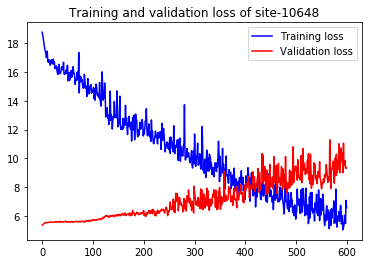

In [97]:
plot_train_history(history_10648, 'Training and validation loss of site-10648')

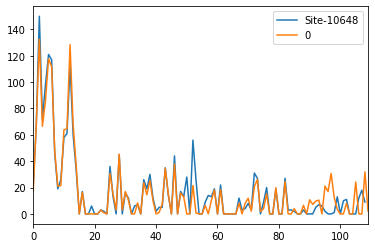

In [98]:
plot_forecast(model_10648 ,site_10648_meeting_data,'Site-10648', window_size,target_size)

In [99]:
site_10648_forcast_1=p_day_forecast(model_10648, site_10648_meeting_data,'Site_10648', window_size, target_size)
site_10648_forcast_1
# site_10648_forcast_1.to_csv( base_dir + r'/prediction/site_10648_forcast_1.csv',index=False)

,Scenario,Site,Timestep,Value
0,Scenario 1,Site_10648,2022-07-15,9.0
1,Scenario 1,Site_10648,2022-07-16,22.0
2,Scenario 1,Site_10648,2022-07-17,11.0
3,Scenario 1,Site_10648,2022-07-18,23.0
4,Scenario 1,Site_10648,2022-07-19,0.0
5,Scenario 1,Site_10648,2022-07-20,0.0
6,Scenario 1,Site_10648,2022-07-21,1.0
7,Scenario 1,Site_10648,2022-07-22,0.0
8,Scenario 1,Site_10648,2022-07-23,0.0
9,Scenario 1,Site_10648,2022-07-24,6.0


Model of Site-7976

In [101]:
tf.keras.backend.clear_session()
model_7976 = tf.keras.models.Sequential()
model_7976.add(tf.keras.layers.GRU(128,
                     dropout=0.1,
                     recurrent_dropout=0.1,
                     return_sequences=True,
                     input_shape=(None, 1)))
model_7976.add(tf.keras.layers.GRU(128,
                     dropout=0.1,
                     recurrent_dropout=0.1,
                     activation='relu'))
model_7976.add(tf.keras.layers.Dense(target_size,  activation='relu' ))


model_7976.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
history_7976 = model_7976.fit_generator(site_7976_train_dataset,
#                               steps_per_epoch=200,
                              epochs=600,
                              validation_data=site_7976_validation_dataset,
#                               validation_steps=200
                             )

Epoch 1/600
2/2 [==============================] - 0s 117ms/step - loss: 9.2497 - val_loss: 0.0000e+00
Epoch 2/600
2/2 [==============================] - 0s 105ms/step - loss: 7.5972 - val_loss: 3.5482
Epoch 3/600
2/2 [==============================] - 0s 107ms/step - loss: 5.5815 - val_loss: 2.1741
Epoch 4/600
2/2 [==============================] - 0s 113ms/step - loss: 5.0064 - val_loss: 2.0337
Epoch 5/600
2/2 [==============================] - 0s 104ms/step - loss: 4.4211 - val_loss: 2.1341
Epoch 6/600
2/2 [==============================] - 0s 107ms/step - loss: 4.4931 - val_loss: 2.0358
Epoch 7/600
2/2 [==============================] - 0s 106ms/step - loss: 4.7955 - val_loss: 2.0560
Epoch 8/600
2/2 [==============================] - 0s 104ms/step - loss: 5.0751 - val_loss: 2.0320
Epoch 9/600
2/2 [==============================] - 0s 104ms/step - loss: 4.1792 - val_loss: 2.0821
Epoch 10/600
2/2 [==============================] - 0s 103ms/step - loss: 4.5260 - val_loss: 2.0694
Epoch

Epoch 83/600
2/2 [==============================] - 0s 107ms/step - loss: 3.8132 - val_loss: 2.0935
Epoch 84/600
2/2 [==============================] - 0s 105ms/step - loss: 3.8202 - val_loss: 2.1640
Epoch 85/600
2/2 [==============================] - 0s 101ms/step - loss: 3.8648 - val_loss: 1.9219
Epoch 86/600
2/2 [==============================] - 0s 103ms/step - loss: 3.8333 - val_loss: 1.8956
Epoch 87/600
2/2 [==============================] - 0s 103ms/step - loss: 3.7893 - val_loss: 1.9428
Epoch 88/600
2/2 [==============================] - 0s 103ms/step - loss: 3.7644 - val_loss: 2.1370
Epoch 89/600
2/2 [==============================] - 0s 104ms/step - loss: 4.1546 - val_loss: 2.2628
Epoch 90/600
2/2 [==============================] - 0s 102ms/step - loss: 3.8528 - val_loss: 2.0630
Epoch 91/600
2/2 [==============================] - 0s 123ms/step - loss: 3.7159 - val_loss: 1.9227
Epoch 92/600
2/2 [==============================] - 0s 127ms/step - loss: 3.7602 - val_loss: 1.9743


2/2 [==============================] - 0s 118ms/step - loss: 3.2717 - val_loss: 2.8892
Epoch 246/600
2/2 [==============================] - 0s 106ms/step - loss: 3.1269 - val_loss: 2.9515
Epoch 247/600
2/2 [==============================] - 0s 103ms/step - loss: 3.1623 - val_loss: 2.7566
Epoch 248/600
2/2 [==============================] - 0s 110ms/step - loss: 3.0632 - val_loss: 2.8032
Epoch 249/600
2/2 [==============================] - 0s 128ms/step - loss: 3.1360 - val_loss: 2.8338
Epoch 250/600
2/2 [==============================] - 0s 106ms/step - loss: 3.0830 - val_loss: 2.9708
Epoch 251/600
2/2 [==============================] - 0s 103ms/step - loss: 3.0086 - val_loss: 2.5800
Epoch 252/600
2/2 [==============================] - 0s 105ms/step - loss: 3.2085 - val_loss: 2.7429
Epoch 253/600
2/2 [==============================] - 0s 130ms/step - loss: 3.0412 - val_loss: 2.5998
Epoch 254/600
2/2 [==============================] - 0s 122ms/step - loss: 3.2679 - val_loss: 2.6874
Epoc

2/2 [==============================] - 0s 103ms/step - loss: 2.2529 - val_loss: 2.8026
Epoch 408/600
2/2 [==============================] - 0s 105ms/step - loss: 2.0474 - val_loss: 2.9441
Epoch 409/600
2/2 [==============================] - 0s 105ms/step - loss: 2.0226 - val_loss: 2.8461
Epoch 410/600
2/2 [==============================] - 0s 103ms/step - loss: 1.9728 - val_loss: 2.8867
Epoch 411/600
2/2 [==============================] - 0s 104ms/step - loss: 2.2056 - val_loss: 2.8087
Epoch 412/600
2/2 [==============================] - 0s 103ms/step - loss: 2.2397 - val_loss: 2.9879
Epoch 413/600
2/2 [==============================] - 0s 106ms/step - loss: 2.1894 - val_loss: 2.8796
Epoch 414/600
2/2 [==============================] - 0s 106ms/step - loss: 2.0547 - val_loss: 2.8899
Epoch 415/600
2/2 [==============================] - 0s 104ms/step - loss: 2.1679 - val_loss: 3.0160
Epoch 416/600
2/2 [==============================] - 0s 104ms/step - loss: 1.8135 - val_loss: 2.9814
Epoc

2/2 [==============================] - 0s 104ms/step - loss: 1.4306 - val_loss: 2.7375
Epoch 570/600
2/2 [==============================] - 0s 106ms/step - loss: 1.4576 - val_loss: 2.7680
Epoch 571/600
2/2 [==============================] - 0s 103ms/step - loss: 1.4202 - val_loss: 2.8520
Epoch 572/600
2/2 [==============================] - 0s 105ms/step - loss: 1.4523 - val_loss: 2.6788
Epoch 573/600
2/2 [==============================] - 0s 103ms/step - loss: 1.6076 - val_loss: 2.9387
Epoch 574/600
2/2 [==============================] - 0s 103ms/step - loss: 1.2303 - val_loss: 2.9807
Epoch 575/600
2/2 [==============================] - 0s 105ms/step - loss: 1.3606 - val_loss: 2.6513
Epoch 576/600
2/2 [==============================] - 0s 104ms/step - loss: 1.6400 - val_loss: 2.8623
Epoch 577/600
2/2 [==============================] - 0s 104ms/step - loss: 1.5275 - val_loss: 2.8086
Epoch 578/600
2/2 [==============================] - 0s 105ms/step - loss: 1.4137 - val_loss: 2.8825
Epoc

In [92]:
plot_train_history(history_7976, 'Training and validation loss of site-7976')

NameError: name 'history_7976' is not defined

In [ ]:
plot_forecast(model_7976 ,site_7976_meeting_data,'Site-7976', window_size,target_size)

In [ ]:
site_7976_forcast_1=p_day_forecast(model_7976, site_7976_meeting_data,'Site_7976', window_size, target_size)
site_7976_forcast_1
# site_7976_forcast_1.to_csv( base_dir + r'/prediction/site_7976_forcast_1.csv',index=False)

<p style="font-family: Arial; font-size:1.25em;color:#2462C0; font-style:bold">
Building and Training Model for Scenerio 2</p>

In [7]:
CLOSED_SITES =['Site-2627', 'Site-2628', 'Site-2630', 'Site-2634', 'Site-2636',
                'Site-2637', 'Site-2638', 'Site-5297', 'Site-5300', 'Site-5308',
                'Site-5309', 'Site-5311', 'Site-7968', 'Site-7969', 'Site-7979',
                'Site-10640', 'Site-10649', 'Site-10650', 'Site-10651', 'Site-10652']
    
PRED_SITES=['Site-2629','Site-5298','Site-5299','Site-10648', 'Site-7976']

site_2629_meeting_data_1 = get_meeting_data(initial_data_1, 'Site-2629')
site_2629_meeting_data_2 = get_meeting_data(initial_data_2, 'Site-2629')
site_2629_meeting_data =  pd.concat([site_2629_meeting_data_1, site_2629_meeting_data_2])



def concat_site_meeting_data(site):
    site_data_1 = get_meeting_data(initial_data_1, site)
    site_data_2 = get_meeting_data(initial_data_2, site)
    site_data =  pd.concat([site_data_1, site_data_2])

    ret = site_data
    for close_site in CLOSED_SITES:
        close_site_meeting_data_1 = get_meeting_data(initial_data_1, close_site)
        close_site_meeting_data_2 = get_meeting_data(initial_data_2, close_site)
        close_site_meeting_data = pd.concat([close_site_meeting_data_1, close_site_meeting_data_2])

        ret = pd.concat([ret,close_site_meeting_data], axis=1, sort=False)
    return ret

    

In [8]:
sites_meeting_data={}
for site in PRED_SITES:
    concat_site_data=concat_site_meeting_data(site)
    sites_meeting_data[site]=concat_site_data
    sites_meeting_data[site]=sites_meeting_data[site].fillna(0)

In [9]:
for site in PRED_SITES:
    sites_meeting_data[site]=sites_meeting_data[site].fillna(0)


,Site-2629,Site-2627,Site-2628,Site-2630,Site-2634,Site-2636,Site-2637,Site-2638,Site-5297,Site-5300,...,Site-5309,Site-5311,Site-7968,Site-7969,Site-7979,Site-10640,Site-10649,Site-10650,Site-10651,Site-10652
Timestep,,,,,,,,,,,,,,,,,,,,,
2019-08-01,34,5.0,27.0,11.0,7,34.0,12.0,1.0,44.0,10,...,60,20,0.0,23.0,3.0,52.0,15.0,50,1.0,25.0
2019-08-02,38,0.0,0.0,8.0,11,20.0,9.0,0.0,31.0,1,...,58,17,0.0,34.0,5.0,33.0,11.0,39,1.0,36.0
2019-08-03,64,3.0,27.0,34.0,27,88.0,16.0,8.0,94.0,5,...,104,31,0.0,57.0,6.0,92.0,22.0,97,3.0,100.0
2019-08-04,53,7.0,15.0,35.0,10,62.0,14.0,3.0,27.0,15,...,67,46,0.0,39.0,3.0,76.0,21.0,83,1.0,57.0
2019-08-05,18,0.0,8.0,14.0,14,22.0,7.0,3.0,28.0,9,...,48,20,0.0,22.0,0.0,38.0,11.0,34,3.0,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-09,8,1.0,14.0,0.0,8,3.0,0.0,0.0,2.0,1,...,14,3,0.0,4.0,0.0,16.0,0.0,23,0.0,17.0
2022-07-10,0,2.0,8.0,2.0,6,8.0,0.0,1.0,0.0,1,...,13,0,0.0,0.0,0.0,5.0,0.0,0,1.0,14.0
2022-07-11,16,0.0,6.0,5.0,2,12.0,0.0,0.0,8.0,2,...,7,4,0.0,0.0,0.0,10.0,0.0,0,0.0,0.0


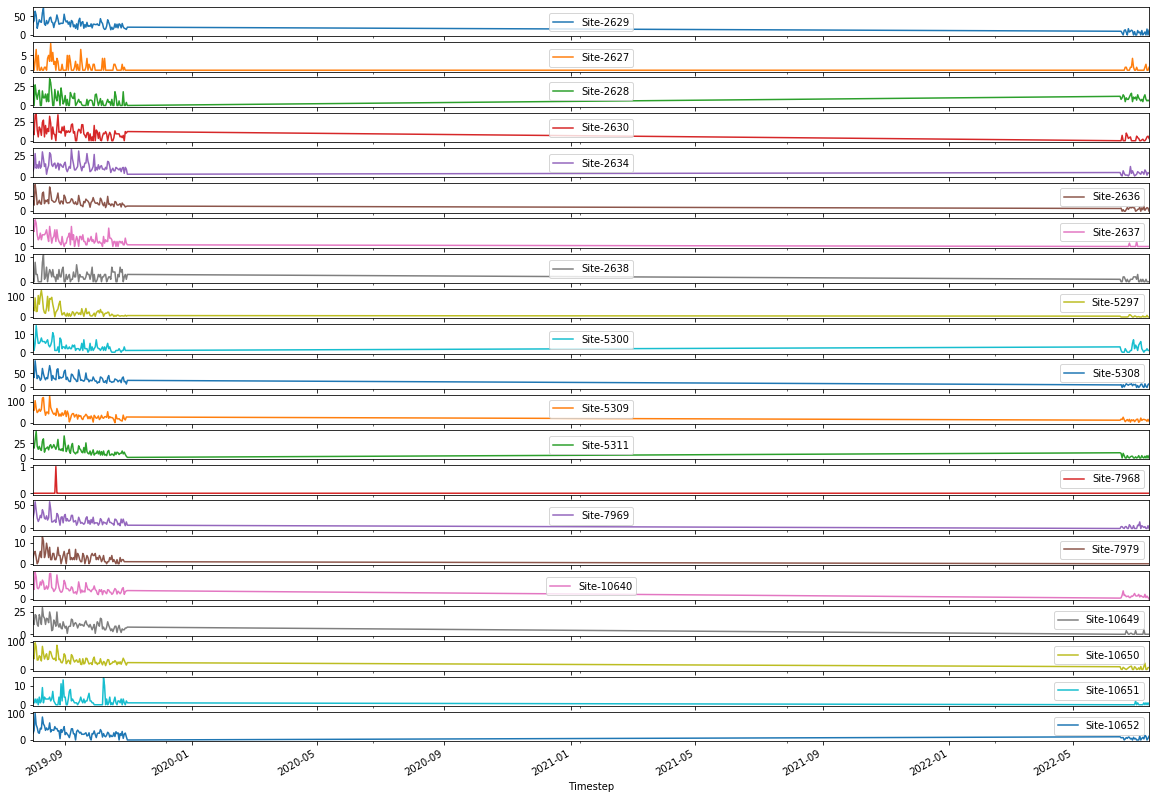

In [10]:
sites_meeting_data['Site-2629'].plot(figsize=(20, 15),subplots=True)                   
sites_meeting_data['Site-2629']

In [102]:
def multivariate_windowed_data(dataframe, window_size, target_size, batch_size,shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices(dataframe)
    dataset = dataset.window(window_size+target_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+target_size))
    dataset = dataset.shuffle(1000)
    dataset = dataset.map(lambda window: (window[:-target_size],window[-target_size:,0:1]))
    dataset = dataset.batch(batch_size).repeat()
    return dataset
    

In [103]:
TRAIN_SPLIT = 100
BATCH_SIZE = 100
window_size = 8
target_size = 5

In [104]:
# site_2629_meeting_values = site_2629_meeting_data.values
# site_2629_meeting_values.shape
sites_meeting_train_dataset={}
sites_meeting_validation_dataset={}
for site_key in sites_meeting_data:
    data=sites_meeting_data[site_key]
    sites_meeting_train_dataset[site_key]=multivariate_windowed_data(data.values[:TRAIN_SPLIT], window_size, target_size, BATCH_SIZE)
    sites_meeting_validation_dataset[site_key]=multivariate_windowed_data(data.values[TRAIN_SPLIT:], window_size, target_size, BATCH_SIZE)


In [105]:
# site_2629_train_dataset = windowed_data(site_2629_meeting_values[:TRAIN_SPLIT], window_size, target_size, BATCH_SIZE)
# site_2629_validation_dataset = windowed_data(site_2629_meeting_values[TRAIN_SPLIT:], window_size, target_size, BATCH_SIZE)

for x, y in sites_meeting_train_dataset['Site-2629'].take(1):
    print('x=',x.shape, 'y=',y.shape)
#     print('x=',x.numpy(), 'y=',y.numpy())

x= (88, 8, 21) y= (88, 5, 1)


In [127]:
tf.keras.backend.clear_session()
def train_model(train_dataset, validation_dataset, epochs):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.GRU(32,
                         dropout=0.2,
                         recurrent_dropout=0.2,
                         return_sequences=True,
                         input_shape=(None, 21)))
    model.add(tf.keras.layers.GRU(16, 
                         dropout=0.2,
                         recurrent_dropout=0.2,
#                            return_sequences=True,
                           activation='relu'))
#     model.add(tf.keras.layers.GRU(5, 
# #                          dropout=0.1,
# #                          recurrent_dropout=0.5,
#                            activation='relu'))
    model.add(tf.keras.layers.Dense(target_size,activation='relu'))

    model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
    history = model.fit(train_dataset,
                        steps_per_epoch=50,
                                  epochs=100,
                                  validation_data=validation_dataset,
                       validation_steps=50)
    return model, history
    

# for site in PRED_SITES:
site=PRED_SITES[1]
site
model, history = train_model( sites_meeting_train_dataset[site], sites_meeting_validation_dataset[site], 500)
# plot_train_history(history, 'Training and validation loss for'+site) 

Train for 50 steps, validate for 50 steps
Epoch 1/100
50/50 [==============================] - 4s 71ms/step - loss: 37.2877 - val_loss: 11.9159
Epoch 2/100
50/50 [==============================] - 1s 16ms/step - loss: 20.2544 - val_loss: 11.5657
Epoch 3/100
50/50 [==============================] - 1s 17ms/step - loss: 17.6078 - val_loss: 10.9044
Epoch 4/100
50/50 [==============================] - 1s 17ms/step - loss: 16.9556 - val_loss: 10.6669
Epoch 5/100
50/50 [==============================] - 1s 16ms/step - loss: 16.4766 - val_loss: 9.7731
Epoch 6/100
50/50 [==============================] - 1s 16ms/step - loss: 15.9430 - val_loss: 9.1426
Epoch 7/100
50/50 [==============================] - 1s 17ms/step - loss: 15.6476 - val_loss: 8.4065
Epoch 8/100
50/50 [==============================] - 1s 16ms/step - loss: 15.3374 - val_loss: 8.4392
Epoch 9/100
50/50 [==============================] - 1s 16ms/step - loss: 15.1174 - val_loss: 8.1214
Epoch 10/100
50/50 [=========================

Epoch 81/100
50/50 [==============================] - 1s 16ms/step - loss: 10.0735 - val_loss: 8.9665
Epoch 82/100
50/50 [==============================] - 1s 16ms/step - loss: 10.0534 - val_loss: 9.2534
Epoch 83/100
50/50 [==============================] - 1s 16ms/step - loss: 10.0005 - val_loss: 9.2726
Epoch 84/100
50/50 [==============================] - 1s 16ms/step - loss: 9.8844 - val_loss: 9.8104
Epoch 85/100
50/50 [==============================] - 1s 17ms/step - loss: 9.8401 - val_loss: 10.6250
Epoch 86/100
50/50 [==============================] - 1s 16ms/step - loss: 9.8441 - val_loss: 10.6802
Epoch 87/100
50/50 [==============================] - 1s 16ms/step - loss: 9.7692 - val_loss: 10.7769
Epoch 88/100
50/50 [==============================] - 1s 17ms/step - loss: 9.7267 - val_loss: 10.5656
Epoch 89/100
50/50 [==============================] - 1s 16ms/step - loss: 9.7969 - val_loss: 10.9374
Epoch 90/100
50/50 [==============================] - 1s 16ms/step - loss: 9.8057 -

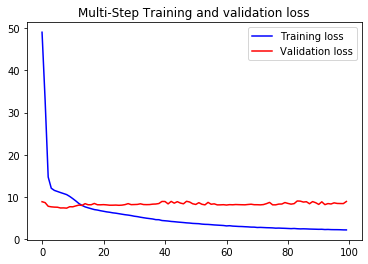

In [124]:
plot_train_history(history, 'Multi-Step Training and validation loss')

In [124]:
# for site in PRED_SITES:
plot_forecast_scene_2(model ,sites_meeting_data[site],site, window_size,target_size)
pred = p_day_forecast_scene_2(model,sites_meeting_data[site],site,window_size, target_size)
# print(pred)
pred['Value'].plot()


NameError: name 'plot_forecast_scene_2' is not defined

In [116]:

pred.to_csv( base_dir + r'/prediction/'+site+'_forcast_2.csv',index=False)

In [61]:
def p_day_forecast_scene_2(model, data, site, window_size, target_size):
    last_date=data.index[-1]
    after_p_day = datetime(2022, 7, 15)
    delta = after_p_day-last_date
    x = data.values[-window_size:]
    for time in range (0, 30 + delta.days,target_size):
        pred = model.predict(x[np.newaxis, time:time+window_size].astype(np.float32)) 
        pred = pred.reshape((target_size,1))
        pred=np.rint(pred)
        y = np.empty((target_size, x.shape[1]))
        y[:,0:1]=pred
        y[:,1:]=0
        x = np.concatenate([x, y], axis=0)
    
    index=pd.date_range(data.index[-window_size], periods=x.shape[0])
    x=pd.DataFrame(x[:,0],index=index,columns=['Value'])
    x.index.rename('Timestep',inplace=True)
    x = x[after_p_day:after_p_day+timedelta(30)]
    x['Scenario']='Scenario 2'
    x['Site'] = site
    x = x.reset_index()
    x=x[['Scenario','Site','Timestep','Value']]
    return x


# p_day_forecast_scene_2(model,sites_meeting_data['Site-2629'],'Site-2629',window_size, target_size)

In [69]:
def plot_forecast_scene_2(model, data, site, window_size,target_size):
    forecast = []
    values=data.values
    for time in range(0, len(values) - window_size,target_size):
        x=values[time:time + window_size][np.newaxis].astype(np.float32)
        pred = model.predict(x)
        pred = pred.reshape(target_size)
        forecast.append(pred)
    forecast = np.array(forecast).reshape(-1)
    res = pd.concat([data[window_size:].reset_index()[site], pd.DataFrame(forecast)], axis =1)
    res.plot()

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold">
Predict Test Question 6
</p> 

In [ ]:
def f_day_forecast(model, data, site, window_size, target_size):
    last_date=data.index[-1]
    f_day = datetime(2022, 7, 14)
    start_day = f_day-timedelta(window_size)
    print(start_day)
    
    
    x = data.values[start_day:start_day+window_size]
    pred = model.predict(x[np.newaxis, time:time+window_size].astype(np.float32)) 
    pred = pred.reshape((target_size,1))
    pred=np.rint(pred) 
    print(pred)
    print(pred[0])
#     for time in range (0, 30 + delta.days,target_size):
#         pred = model.predict(x[np.newaxis, time:time+window_size].astype(np.float32)) 
#         pred = pred.reshape((target_size,1))
#         pred=np.rint(pred) 
#         x = np.concatenate([x, pred], axis=0)
    
#     index=pd.date_range(data.index[-window_size], periods=x.shape[0])
#     x=pd.DataFrame(x,index=index, columns=['Value'])
#     x.index.rename('Timestep',inplace=True)
#     x = x[p_day:p_day+timedelta(30)]
#     x['Scenario']='Scenario 1'
#     x['Site'] = site
#     x = x.reset_index()
#     x=x[['Scenario', 'Site', 'Timestep', 'Value']]
    return pred[0]
    